# Построение модели МО для компании «Работа с заботой» для анализа удовлетворённости сотрудников и прогнозирование оттока.

### Цели исследования.

- Загрузка , обработка и анализ поступивших от заказчика данных , с целью подготовки данных для обучения МО и выявления полезных бизнесу закономерностей.

- Построение модели МО , которая сможет предсказать уровень удовлетворённости сотрудника на основе данных от заказчика.



### Ход исследования.

- Загрузка и первичное ознакомление с данными.

- Предобработка данных и выявление пропусков.

- Исследовательский анализ данных

- Созднание "пайнлайна" с применением обработки данных и использованием различных моделей МО и анализ результатов лучшей модели по метрике SMAPE.

- Выводы по задаче предсказания уровня удовлетворенности сотрудников.

- Проведение аналогичных шагов , и оформление выводов по задаче прогнозирования увольнения сотрудника.

### Описание поступивших данных.

`id` — уникальный идентификатор сотрудника;

`dept` — отдел, в котором работает сотрудник;

`level` — уровень занимаемой должности;

`workload` — уровень загруженности сотрудника;

`employment_years` — длительность работы в компании (в годах);

`last_year_promo` — показывает, было ли повышение за последний год;

`last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;

`supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;

`salary` — ежемесячная зарплата сотрудника;

`job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

## Техническая секция

### Импорт и установка библиотек

In [1]:
#%pip install phik -q
#%pip install --upgrade ipywidgets -q


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import shap
import phik
import warnings
import time
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.metrics import (r2_score, 
                             mean_squared_error, 
                             mean_absolute_error, 
                             accuracy_score, precision_score,
                             recall_score, 
                             confusion_matrix, 
                             precision_recall_curve, 
                             classification_report, 
                             roc_auc_score, 
                             make_scorer, 
                             f1_score)
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, SVR
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
warnings.filterwarnings("ignore", category=FutureWarning) 
RS = 42


### Определение функций

In [4]:
def check_data_dubmiss(df, df_name='DataFrame'):
    """
    Анализирует DataFrame на дубликаты и пропущенные значения.
    Возвращает единый отчет в виде DataFrame с категориями.

    Параметры:
    - df: pandas DataFrame для проверки
    - df_name: название DataFrame для отчета

    Возвращает:
    - Единый DataFrame с отчетом
    """
    report_parts = []

    # 1. Общая информация
    info_df = pd.DataFrame({
        'Категория': ['Общая информация'],
        'Параметр': ['Название датафрейма'],
        'Значение': [df_name],
        'Детали': [f'Размер : {df.shape[0]} x {df.shape[1]}']
    })
    report_parts.append(info_df)

    # 2. Дубликаты
    duplicates = df.duplicated().sum()
    duplicates_df = pd.DataFrame({
        'Категория': ['Дубликаты', 'Дубликаты'],
        'Параметр': ['Всего дубликатов', 'Примеры дубликатов'],
        'Значение': [duplicates, duplicates > 0],
        'Детали': ['', f"Первые {min(5, duplicates)} примеров" if duplicates > 0 else '']
    })
    report_parts.append(duplicates_df)

    # 3. Пропущенные значения по столбцам
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    
    if missing.sum() > 0:
        missing_df = pd.DataFrame({
            'Категория': ['Пропущенные значения'] * len(missing),
            'Параметр': missing.index,
            'Значение': missing.values,
            'Детали': [f"{pct:.2f}%" for pct in missing_pct.values]
        })
        missing_df = missing_df[missing_df['Значение'] > 0]
        report_parts.append(missing_df)

    # 4. Итог по пропущенным значениям
    total_missing_df = pd.DataFrame({
        'Категория': ['Пропуски'],
        'Параметр': ['Всего пропущенных значений'],
        'Значение': [missing.sum()],
        'Детали': [f"{missing.sum() / df.size:.2%} от всех ячеек"]
    })
    report_parts.append(total_missing_df)

    report = pd.concat(report_parts, ignore_index=True)

    if duplicates > 0:
        duplicates_examples = df[df.duplicated(keep=False)].sort_values(by=df.columns.tolist()).head()
        report.at[4, 'Детали'] = str(duplicates_examples.to_dict('records'))

    return report

In [5]:
sns.set_style('whitegrid')
sns.set_palette('RdYlBu')
def graph_cat(df, columns, title, xlabel):
    """
    Визуализирует категориальные данные с помощью круговой диаграммы и столбчатой диаграммы.

    Параметры:
    -----------
    df : pandas.DataFrame
        DataFrame, содержащий данные.
    columns : str
        Название столбца с категориальными данными для визуализации.
    title : str
        Заголовок графика.
    xlabel : str
        Подпись оси X.

    
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    df[columns].value_counts().plot(kind='pie', y='count', x='subscription_type',
                           colors=sns.color_palette('plasma'),ax=ax[0], autopct='%1.1f%%')
    ax[0].set_title('Процентное ' + title)
    ax[0].set_ylabel(' ')

    sorted_order = df[columns].value_counts().sort_values(ascending=False).index
    sns.countplot(data=df, y=columns, ax=ax[1], order=sorted_order, palette='plasma')
    #sns.countplot(data=df, x=columns, ax=ax[1], palette=['grey', 'orange', 'lightblue'], orient='h')
    ax[1].set_title('Колличественное '+ title)
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel('Тип переменной')

In [6]:
def graph_num(df, columns, title, xlabel, bins=30):
    """
    Визуализирует числовые данные с помощью гистограммы и boxplot.

    Параметры:
    -----------
    df : pandas.DataFrame
        DataFrame, содержащий данные для анализа.
    columns : str
        Название столбца с числовыми данными, которые будут визуализированы.
    title : str
        Заголовок графика (добавляется к описанию гистограммы и boxplot).
    xlabel : str
        Подпись оси X для гистограммы.
    bins : int, optional
        Количество интервалов (бинов) для гистограммы. По умолчанию 30.

    
    """
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    sns.histplot(data=df, x=columns, kde=True, color='blue', bins=bins, ax=ax[0])
    ax[0].set_title('Гистограмма признака '+ title)
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('Кол-во')
    
    sns.boxplot(data=df[columns], orient='h', ax=ax[1])
    ax[1].set_title('Разброс значений признака '+ title)
    ax[1].set_xlabel('Значения')
    ax[1].set_ylabel(' ')

## Импорт и загрузка данных.

In [7]:
try:
    df_train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
except:
    df_train = pd.read_csv(r'C:\jupi\datasets\train_job_satisfaction_rate.csv')
try:
    df_test = pd.read_csv('/datasets/test_features.csv')
except:
    df_test = pd.read_csv(r'C:\jupi\datasets\test_features.csv')
try:
    df_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
except:
    df_target = pd.read_csv(r'C:\jupi\datasets\test_target_job_satisfaction_rate.csv')   


### Первичное ознакомление с данными.

#### df_train

In [8]:
display(df_train.shape) 
display(df_train.head(5)) 
display(df_train.info()) 
display(df_train.drop('id', axis=1).describe())

(4000, 10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


При первом ознакомлении , за исключением нескольких пропусков , данные подозрений не вызывают.

#### df_test

In [9]:
display(df_test.shape) 
display(df_test.head(5)) 
display(df_test.info()) 
display(df_test.drop('id', axis=1).describe())

(2000, 9)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


В данных так же присутствует несколько пропусков , рассмотрим их на этапе предобработки , в остальном данные представлены нормально.

#### df_target

In [10]:
display(df_target.shape) 
display(df_target.head(5)) 
display(df_target.info()) 
display(df_target.drop('id', axis=1).describe())

(2000, 2)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

,job_satisfaction_rate
count,2000.00000
mean,0.54878
std,0.22011
min,0.03000
25%,0.38000
50%,0.58000
75%,0.72000
max,1.00000


Аномалий в данных с целевым признаком при первичном ознакомлении , обнаружить не удалось.

#### Вывод по блоку

- Загрузка данных прошла нормально , при первичном ознакомлении было обнаружено несколько пропусков в датасетах **df_train и df_test**. Подробней изучим этот дефект на этапе преодобработки , который последует за этим блоком.

## Предобработка данных

### df_train

Проверим датасет на предмет дубликатов и пропущенных значений.

In [11]:
check_data_dubmiss(df_train, 'df_train')

,Категория,Параметр,Значение,Детали
0,Общая информация,Название датафрейма,df_train,Размер : 4000 x 10
1,Дубликаты,Всего дубликатов,0,
2,Дубликаты,Примеры дубликатов,False,
3,Пропущенные значения,dept,6,0.15%
4,Пропущенные значения,level,4,0.10%
5,Пропуски,Всего пропущенных значений,10,0.03% от всех ячеек


В данных обнаружились пропуски в переменных **dept, level**

Рассмотрим их подробней что бы определиться со стратегией обработки.

**Пропуски в "level"**

In [12]:
df_train[df_train['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


In [13]:
df_train.pivot_table(index='dept', columns='level', values='salary', aggfunc='median')

level,junior,middle,sinior
dept,,,
hr,24000.0,39600.0,54000.0
marketing,24000.0,40800.0,55200.0
purchasing,24000.0,38400.0,57600.0
sales,21600.0,38400.0,51600.0
technology,27600.0,44400.0,64800.0


Главным фактором для определения уровня сотрудника , выступает его зарплата (salary), проанализировав медианные значения по всем уровням и сравнив их с нашими показателями , приходим к выводу что оптимальным будет заполнить пропуски в столбце "level" значениями "junior".

Учитывая что все пропущенные значения принадлежат к одному классу , то выполним заполнение на этапе постройки "пайплайна".

**Пропуски в "dept"**

In [14]:
df_train[df_train['dept'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


Посмотрим на как распределилось кол-во сотрудников в каждом отделе.

In [15]:
df_train.value_counts('dept')

dept
sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: count, dtype: int64

Для определения принадлежности сотрудника к определенному отделу так же воспользуемся показателями зарплаты, для этого построим гистограммы зарплат.

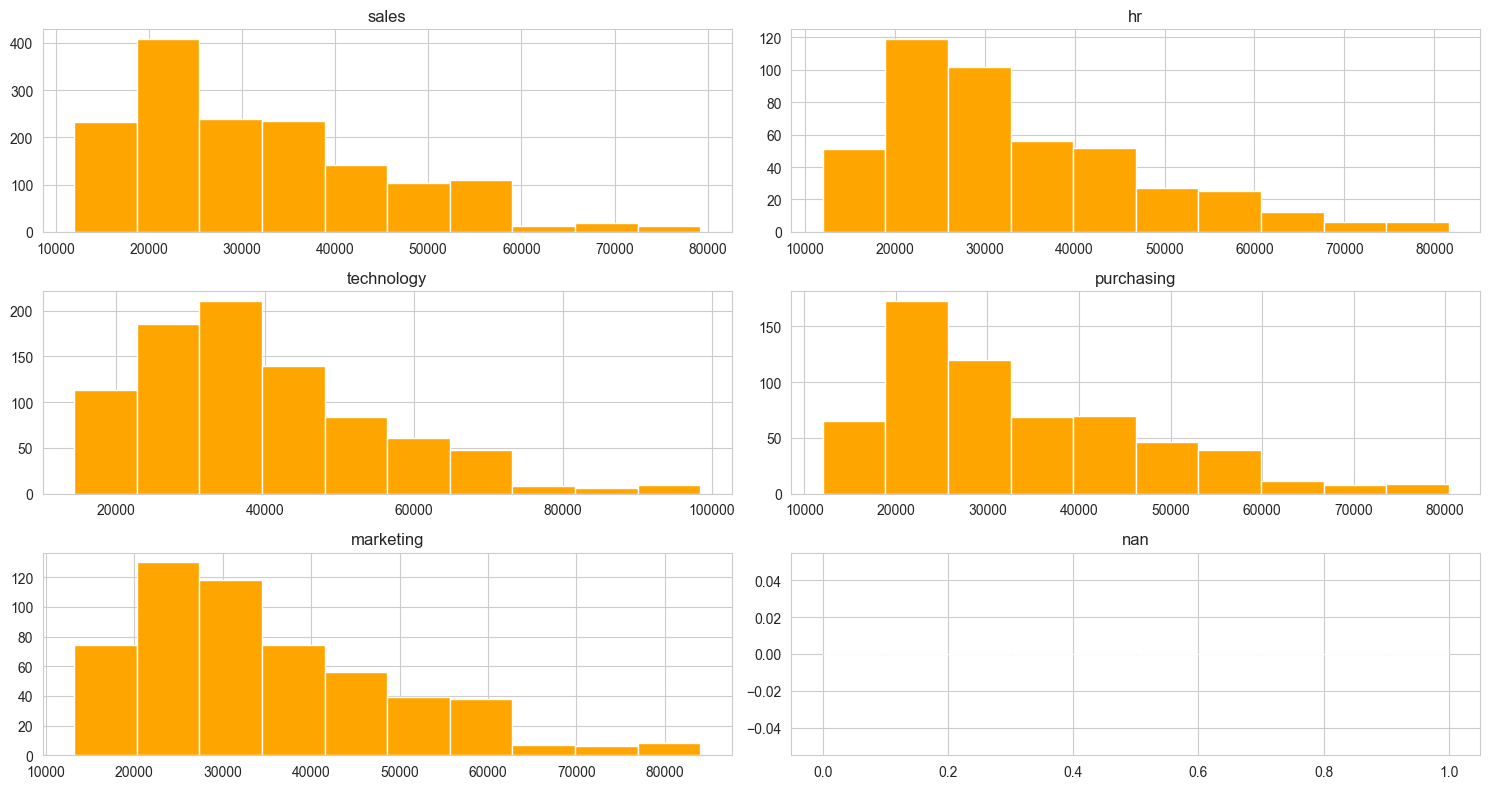

In [16]:
plt.figure(figsize=(15, 8))

depts = df_train['dept'].unique()

rows = (len(depts) + 1) // 2  

for i, dept in enumerate(depts, 1):
    plt.subplot(rows, 2, i) 
    df_train[df_train['dept'] == dept]['salary'].hist(color='orange')
    plt.title(dept)

plt.tight_layout()  # Чтобы подписи не накладывались
plt.show()

Видим что показатели зарплаты в среднем распределены одинаково между всеми отделами. Поэтому в разрезе нашей задачи принадлежность сотрудника к какому либо определенному отделу не так важна , заполним пропуски "модой" , а именно значением "sales". Из за того что пропуски будут заполнены одним значением выполним это на этапе обработки данных в "пайплайне".

Проверим так же уникальные значения категориальных столбцов для обнаружения и обработки опечаток.

In [17]:
cat_cols = df_train.select_dtypes(include='object').columns
cat_cols

Index(['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations'], dtype='object')

In [18]:
for cat in cat_cols :
    print(f"{cat} : {df_train[cat].unique()}")

dept : ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level : ['junior' 'middle' 'sinior' nan]
workload : ['medium' 'high' 'low']
last_year_promo : ['no' 'yes']
last_year_violations : ['no' 'yes']


Ошибок в значениях описательных переменных не обнаружено.

### df_test

Выполним проверку датасета на дубликаты и пропуски.

In [19]:
check_data_dubmiss(df_test, 'df_test')

,Категория,Параметр,Значение,Детали
0,Общая информация,Название датафрейма,df_test,Размер : 2000 x 9
1,Дубликаты,Всего дубликатов,0,
2,Дубликаты,Примеры дубликатов,False,
3,Пропущенные значения,dept,2,0.10%
4,Пропущенные значения,level,1,0.05%
5,Пропуски,Всего пропущенных значений,3,0.02% от всех ячеек


Так же как и в "df_train" обнаружилось несколько пропусков в столбцах **dept и level**

In [20]:
df_test[df_test['dept'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800


In [21]:
df_test[df_test['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
312,471990,sales,NaN,low,1,no,no,3,12000


Выполним проверку уникальных значений в наших данных.

In [22]:
for cat in cat_cols :
    print(f"{cat} : {df_test[cat].unique()}")

dept : ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level : ['junior' 'middle' 'sinior' nan]
workload : ['medium' 'low' 'high' ' ']
last_year_promo : ['no' 'yes']
last_year_violations : ['no' 'yes']


В ходе проверки , удалось обнаружить неявные пропуски.

In [23]:
df_test[df_test['dept'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1699,822186,,middle,medium,3,no,no,4,38400


In [24]:
df_test[df_test['workload'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800


Учитывая что *df_train* и *df_test* имеют одинаковую структуру и распределение числовых переменных. Для обработки пропусков будет использовать аналогичную стратегию что и для *df_train*.

### df_target

In [25]:
check_data_dubmiss(df_target, 'df_target')

,Категория,Параметр,Значение,Детали
0,Общая информация,Название датафрейма,df_target,Размер : 2000 x 2
1,Дубликаты,Всего дубликатов,0,
2,Дубликаты,Примеры дубликатов,False,
3,Пропуски,Всего пропущенных значений,0,0.00% от всех ячеек


Пропусков и дубликатов в *df_target* обнаружено не было.

### Вывод по блоку

- Нами были обнаружены незначительные пропуски в данных , df_train содержит **10** пропусков , в df_test было обнаружено **3** пропущенных значения.

- Проанализировав данные , мы определились со стратегией заполнения недостающих значений , выполнения этого шага будет выполнено на этапе постройки "пайплайна"

## Исследовательский анализ данных

### df_train

#### Категориальные переменные

##### **dept**

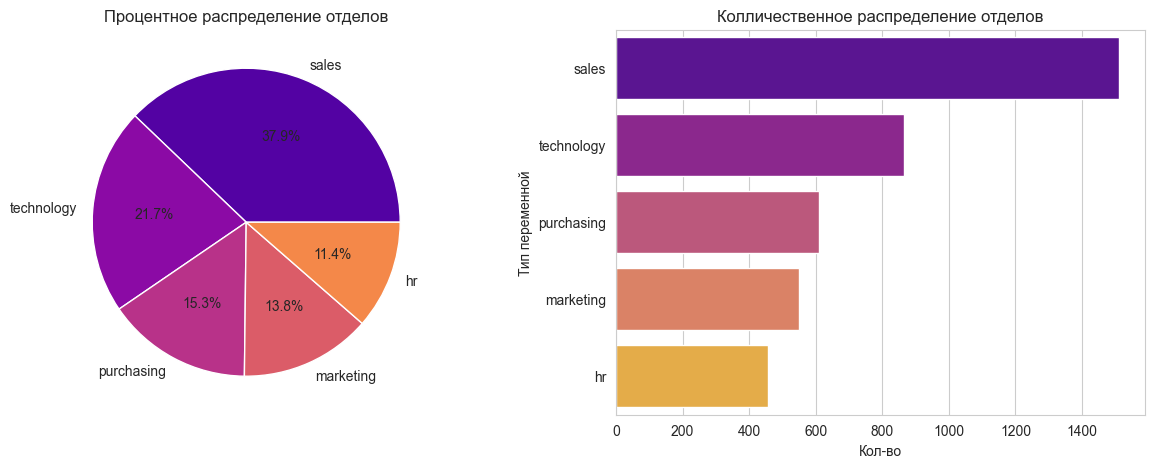

In [26]:
graph_cat(df_train, 'dept', 'распределение отделов', 'Кол-во')

Видим что основная часть сотрудников работает в отделе продажи (sales).

##### **level**

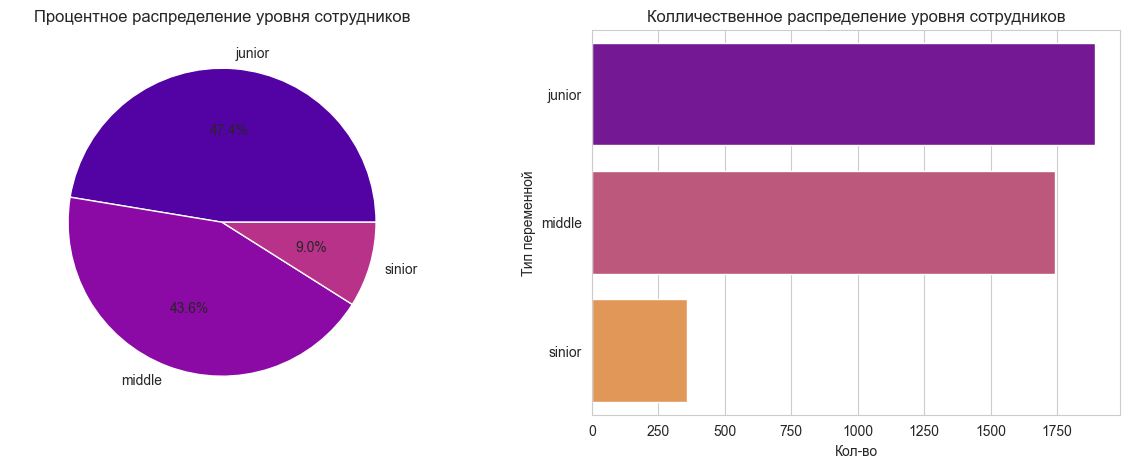

In [27]:
graph_cat(df_train, 'level', 'распределение уровня сотрудников', 'Кол-во')

Уровень квалификации сотрудников компании практически поровну распределился между *junior* и *middle* , самой малочисленной группой оказалась группа "sinior".

##### **workload**

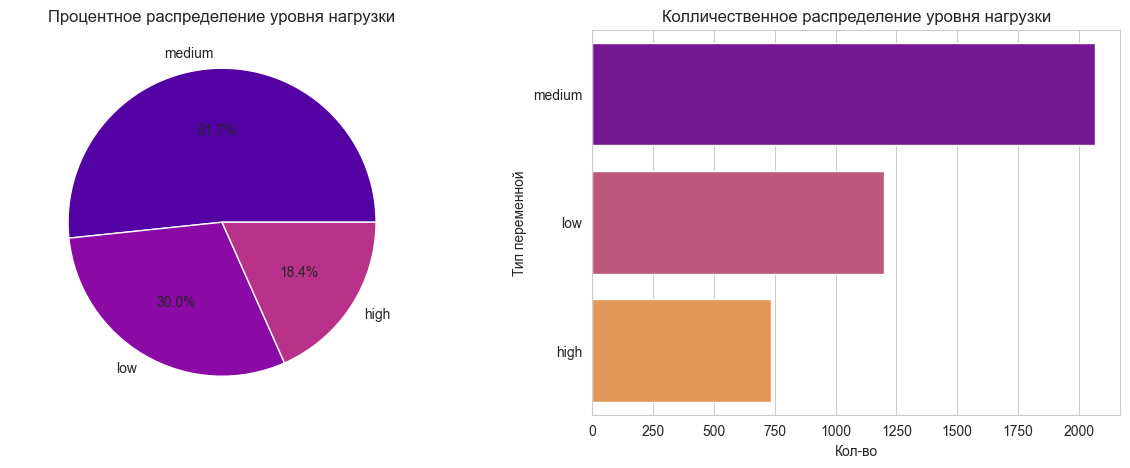

In [28]:
graph_cat(df_train, 'workload', 'распределение уровня нагрузки', 'Кол-во')

Из графика видно что половина сотрудников работает в режиме *medium*

##### **last_year_promo**

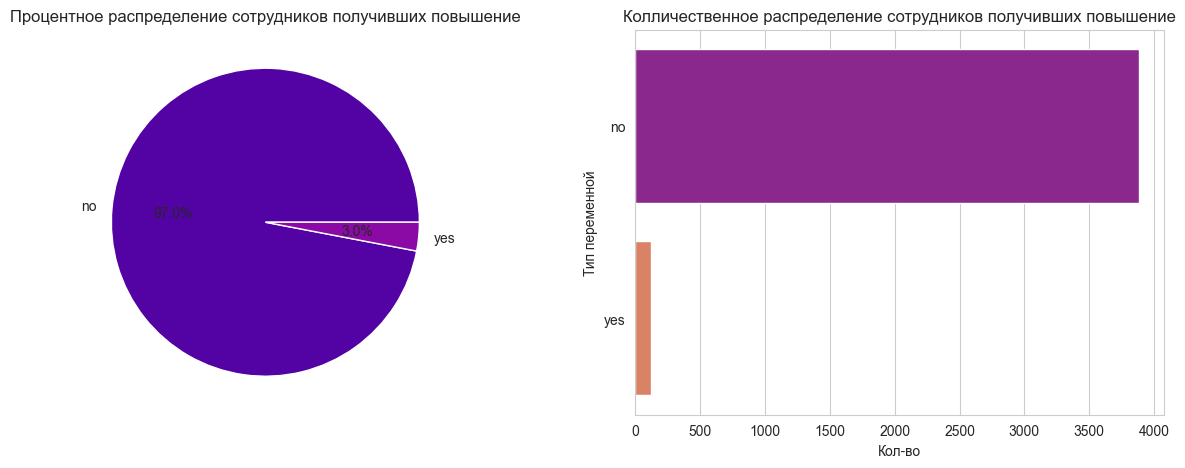

In [29]:
graph_cat(df_train, 'last_year_promo', 'распределение сотрудников получивших повышение', 'Кол-во')

Видим что за прошлый год было повышенно **3%** сотрудников , что вполне логично.

##### last_year_violation

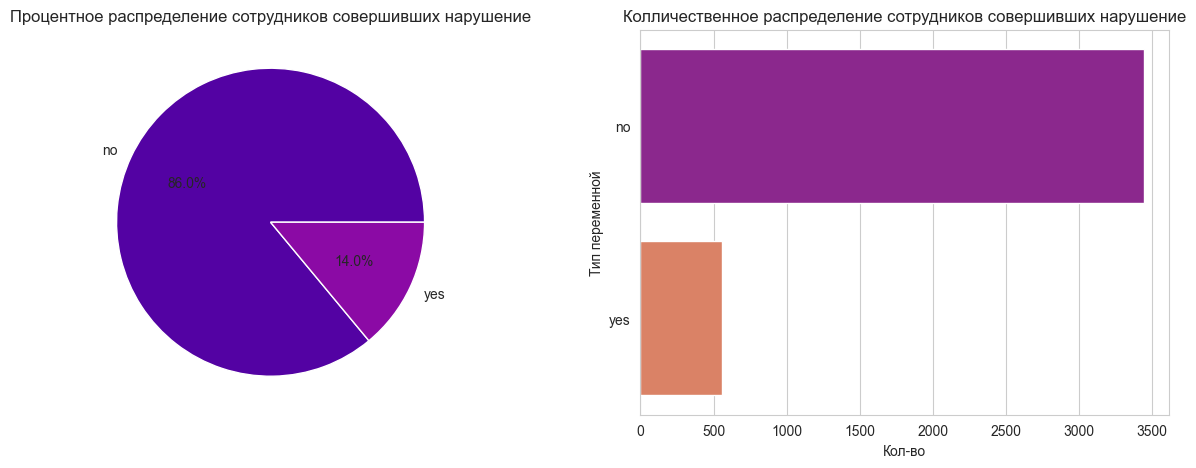

In [30]:
graph_cat(df_train, 'last_year_violations', 'распределение сотрудников совершивших нарушение', 'Кол-во')

Видим что **14%** работающих получили за прошлый год взыскания. В целом данные не вызывают подозрений.

#### Количественные переменные

##### **employment_years**

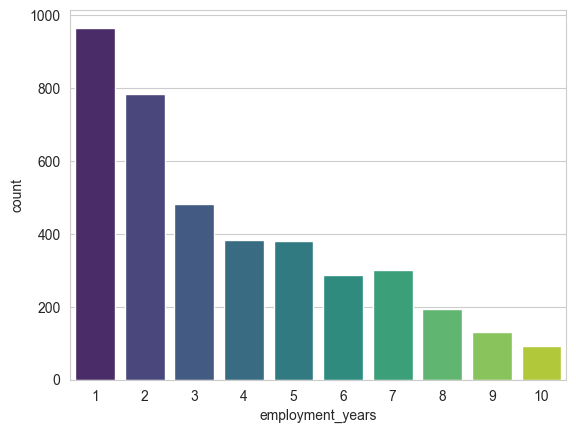

In [31]:
sns.countplot(data=df_train, x='employment_years', palette='viridis');

Видим нормальное распределение для этой переменной , большое количество "свеженанятых" до 3 лет и не большое число "ветеранов". Это согласуется с проведеным нами выше анализом квалификации сотрудников.

##### **supervisor_evaluation**

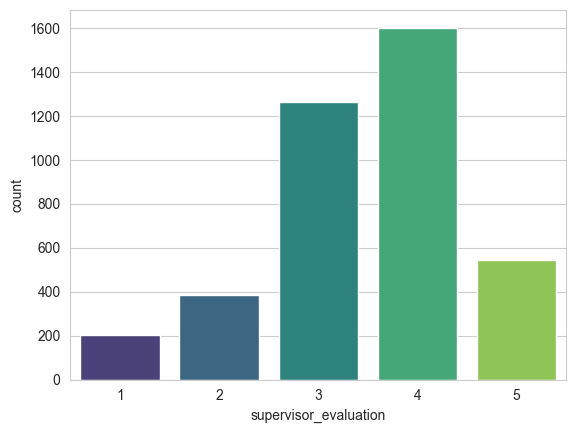

In [32]:
sns.countplot(data=df_train, x='supervisor_evaluation', palette='viridis');

Данные оценок распределены нормально.

##### **salary**

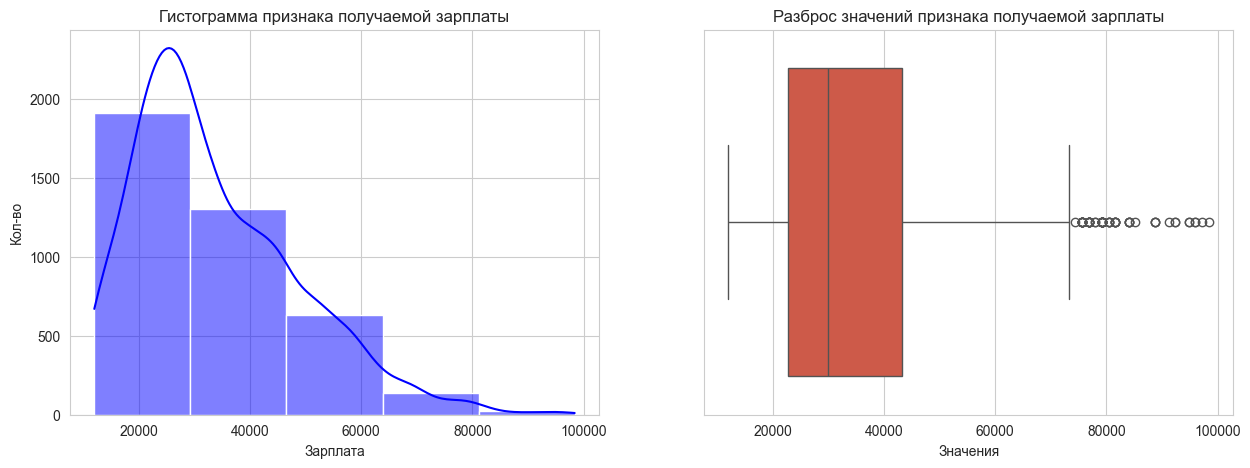

In [33]:
graph_num(df_train, 'salary', 'получаемой зарплаты', 'Зарплата', bins=5)


In [34]:
df_train[df_train['salary'] > 72000]['level'].value_counts()

level
sinior    66
Name: count, dtype: int64

Распределение зарплат выглядит совершенно нормально для рынка труда , видим что все выбросы принадлежат сотрудникам с уровнем *sinior* что вполне закономерно

##### **job_satisfaction_rate**

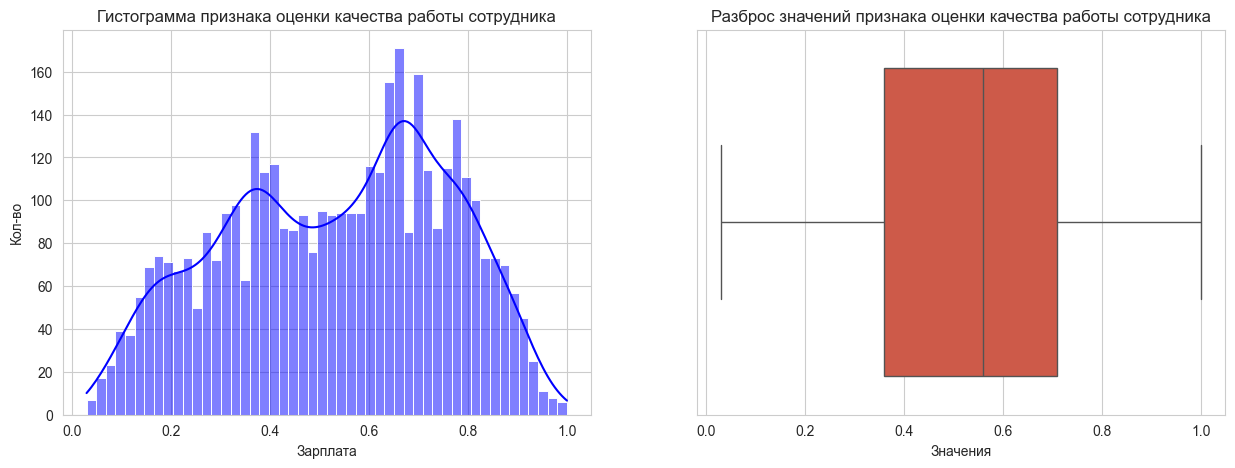

In [35]:
graph_num(df_train, 'job_satisfaction_rate', 'оценки качества работы сотрудника', 'Зарплата', bins=50)


### df_test

Датасет имеет аналогичную структуру что и **df_train** , проведем анализ с целью выявления дефектов данных. Выводы по переменным аналогичны выводам представленным в анализе **df_train** в случае обнаружения расхождений обратим на этом внимание.

#### Категориальные признаки

##### **dept**

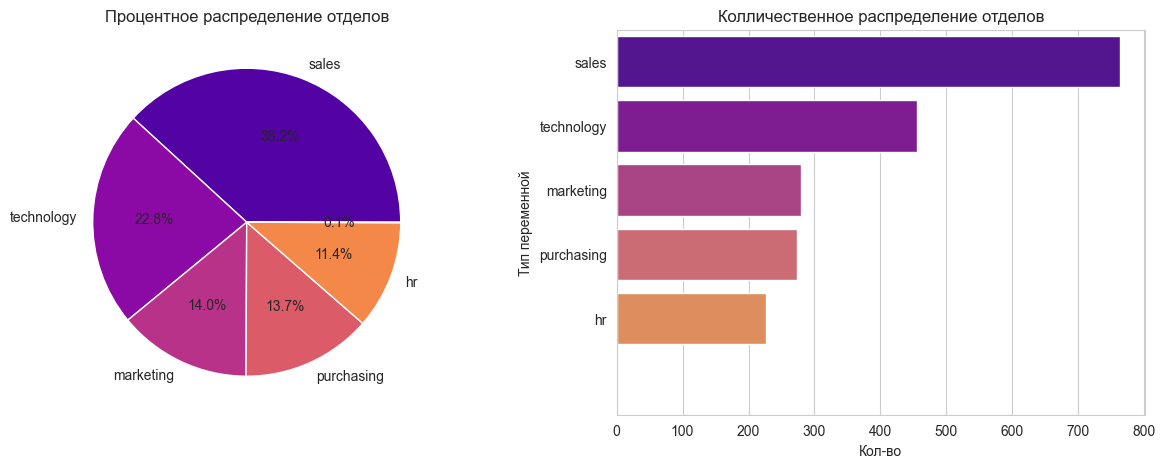

In [36]:
graph_cat(df_test, 'dept', 'распределение отделов', 'Кол-во')

##### **level**

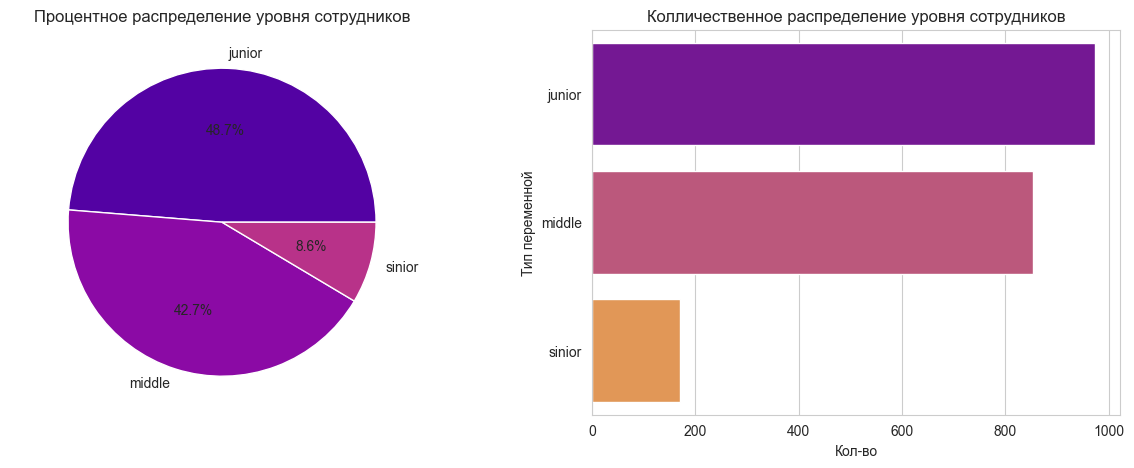

In [37]:
graph_cat(df_test, 'level', 'распределение уровня сотрудников', 'Кол-во')

##### **workload**

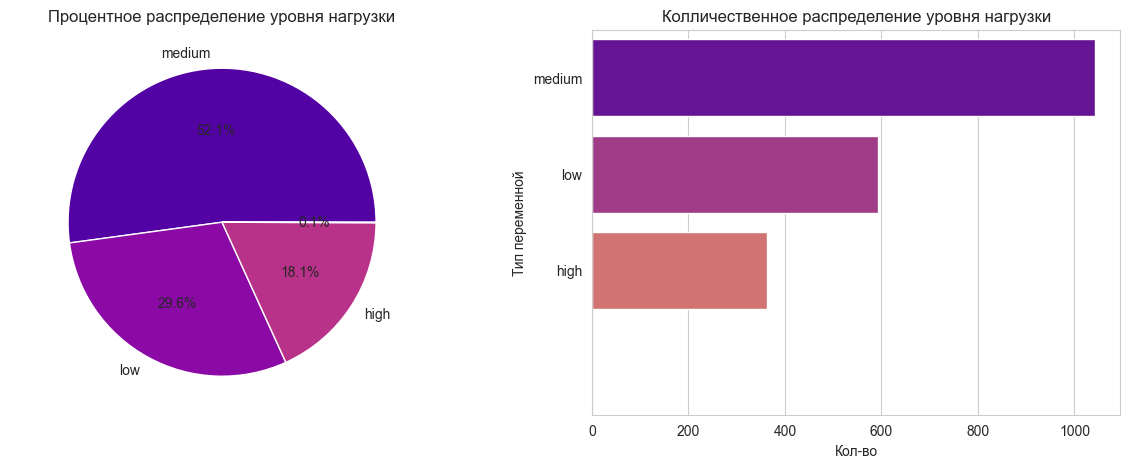

In [38]:
graph_cat(df_test, 'workload', 'распределение уровня нагрузки', 'Кол-во')

##### **last_year_promo**

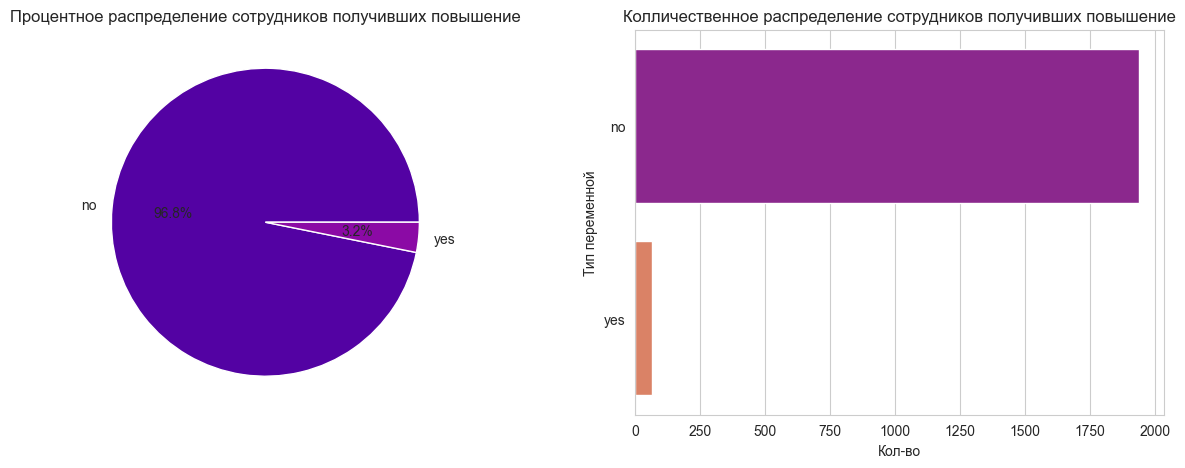

In [39]:
graph_cat(df_test, 'last_year_promo', 'распределение сотрудников получивших повышение', 'Кол-во')

##### last_year_violation

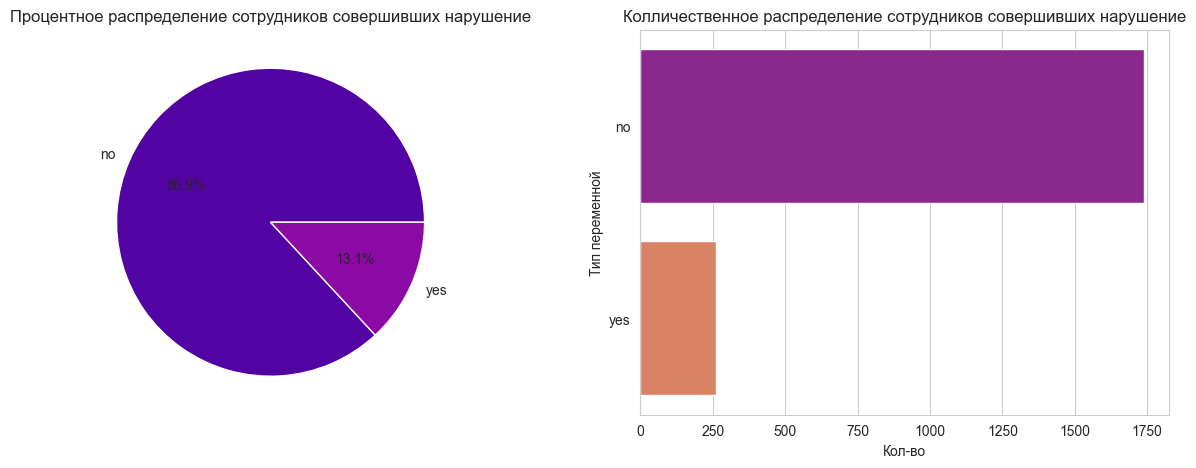

In [40]:
graph_cat(df_test, 'last_year_violations', 'распределение сотрудников совершивших нарушение', 'Кол-во')

#### Количественные признаки.

##### **employment_years**

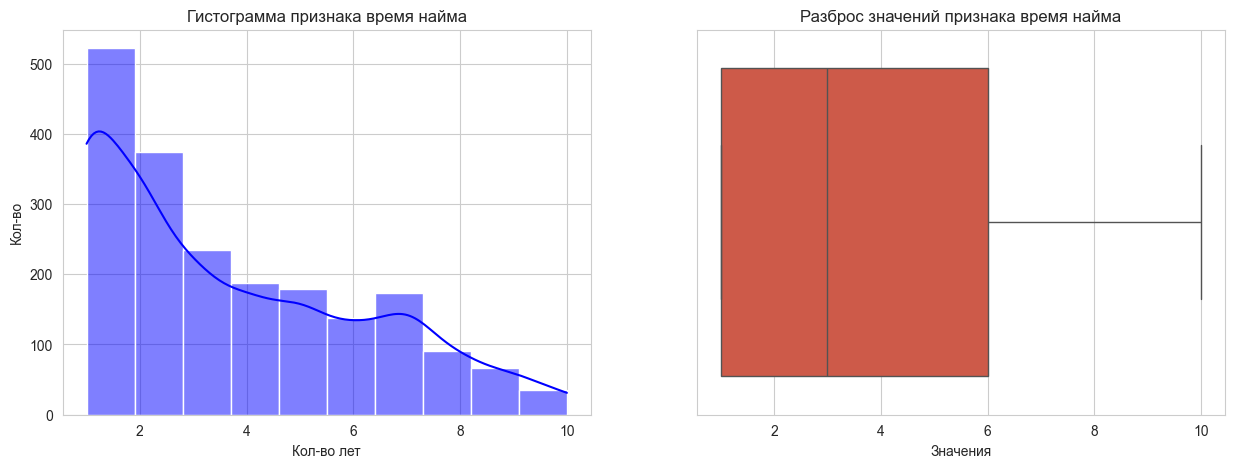

In [41]:
graph_num(df_test, 'employment_years', 'время найма', 'Кол-во лет', bins=10)


##### **supervvisor_evaluation**

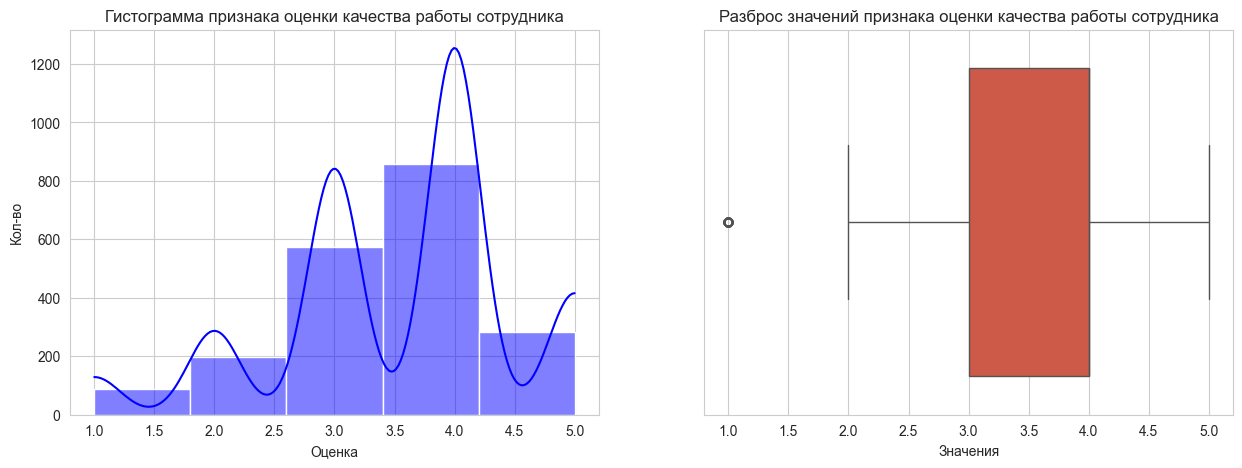

In [42]:
graph_num(df_test, 'supervisor_evaluation', 'оценки качества работы сотрудника', 'Оценка', bins=5)


##### **salary**

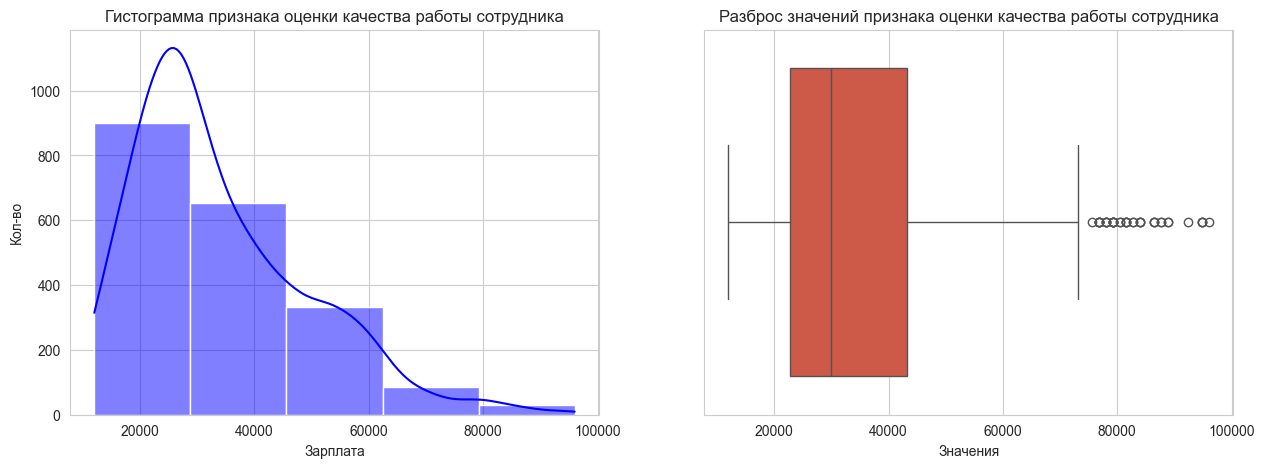

In [43]:
graph_num(df_test, 'salary', 'оценки качества работы сотрудника', 'Зарплата', bins=5)


In [44]:
df_test[df_test['salary'] > 72000]['level'].value_counts()

level
sinior    42
Name: count, dtype: int64

Рассмотренный датафрейм представляющий собой тестовую выборку по структуре и числовым распределениям полностью совпадает с df_train который является датасетом для обучения модели.

Что бы дополнительно в этом убедиться построим гистограммы числовых переменных обоих датасетов.

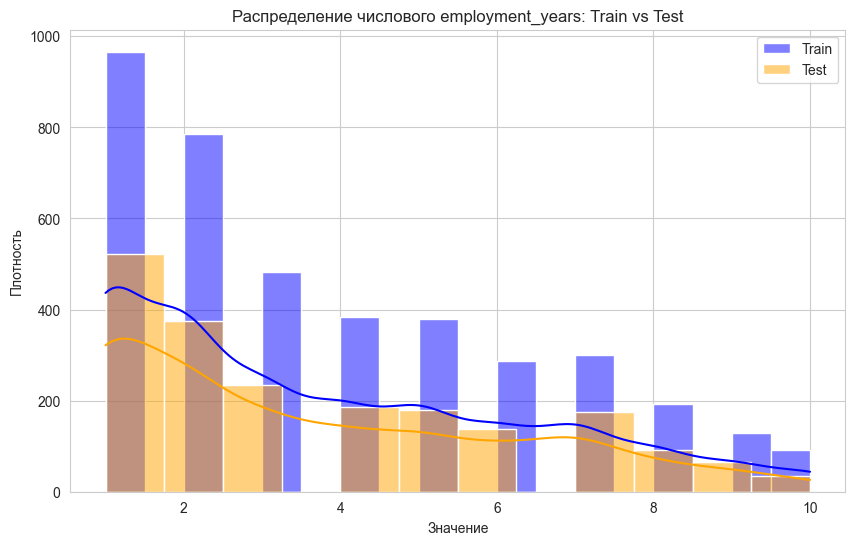

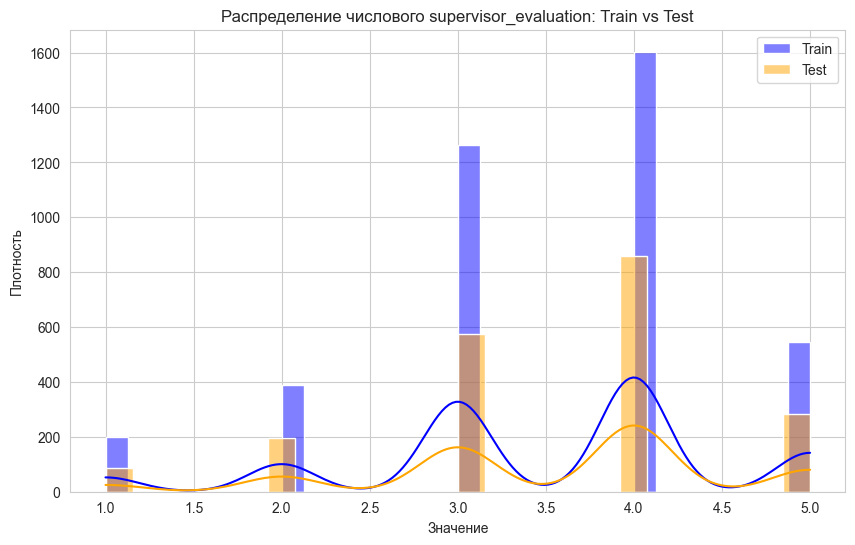

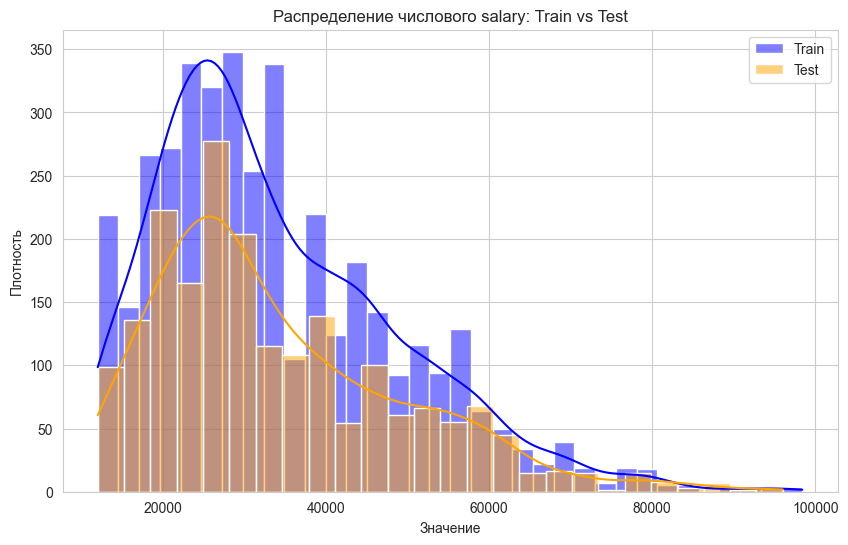

In [45]:
train_data = df_train.copy()
test_data = df_test.copy()

train_data['check'] = 'Train'
test_data['check'] = 'Test'
combined = pd.concat([train_data, test_data])

com_col = combined.select_dtypes(include='number').columns.drop(['job_satisfaction_rate', 'id'])

for col in com_col: 
    plt.figure(figsize=(10, 6))
    sns.histplot(
    data=train_data,
    x=col,
    color='blue',
    label='Train',
    kde=True,           
    alpha=0.5,
)
    sns.histplot(
    data=test_data,
    x=col,
    color='orange',
    label='Test',
    kde=True,
    alpha=0.5,
)
    plt.title(f"Распределение числового {col}: Train vs Test")
    plt.xlabel('Значение')
    plt.ylabel('Плотность')
    plt.legend()
    plt.show()

Видим что несмотря на разный размер датасетов , распределения данных абсолютно идентичны.

### df_target

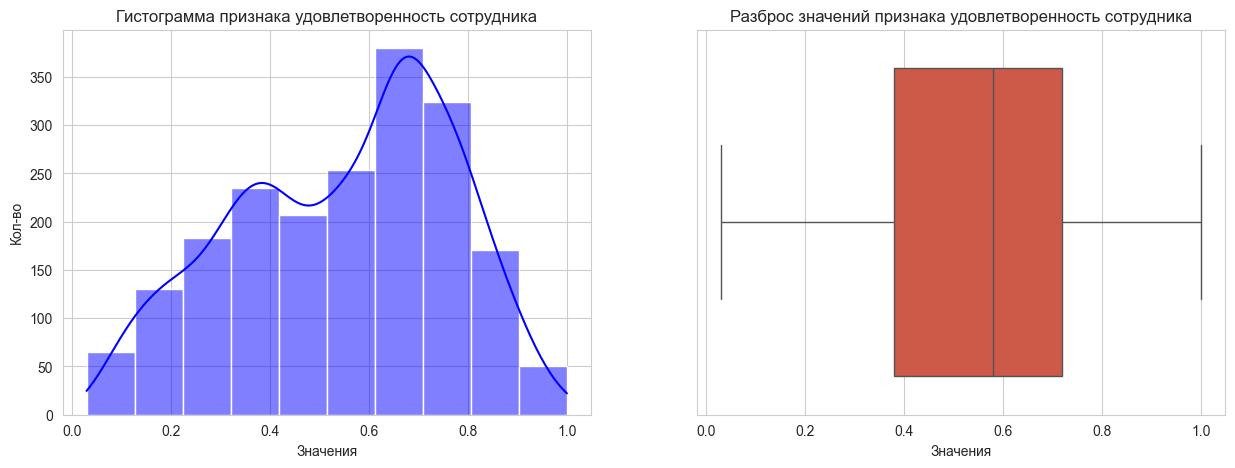

In [46]:
graph_num(df_target, 'job_satisfaction_rate', 'удовлетворенность сотрудника', 'Значения', bins=10)

Целевой признак имеет нормальное распределение и не вызывает каких либо подозрений.

### Выдвижение гипотез.

Перед обучением модели попытаемся выявить закономерности между "удовлетворенностью работой" и другими признаками. Для того что бы на этапе работы с моделью модернизировать входящие признаки.

Создадим категоризацию по уровню удовлетворенности с шагом в **0.2** , переведем категориальные признаки в числовые для построение *диаграммы рассеяния* как самого простого способа для визуализации зависимостей признаков от "уровня удовлетворенности"

Что бы не искажать изначальный датасет новыми признаки , создадим его копию.

In [47]:
df_scatter = df_train.copy()

In [48]:
df_scatter['satisfaction_rate'] = pd.cut(df_train['job_satisfaction_rate'], 
                                       bins=[0, 0.2, 0.4, 0.6, 0.8, 1], 
                                       labels=['very_low', 'low', 'midlle', 'high', 'very_high'])


Проанализируем "удовлетворенность сотрудников" в разрезе выполненной категоризации , с целью выявления дисбаланса классов.

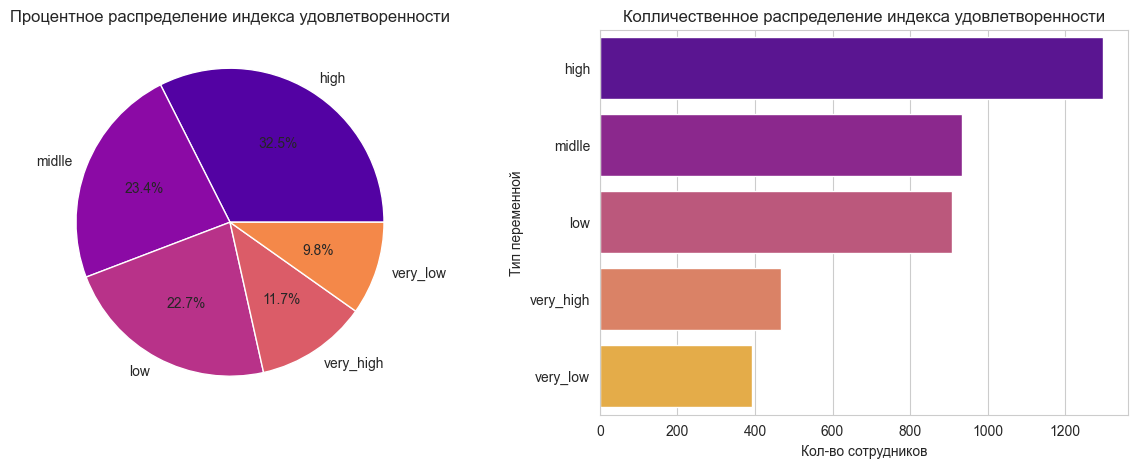

In [49]:
graph_cat(df_scatter, 'satisfaction_rate', 'распределение индекса удовлетворенности', 'Кол-во сотрудников')

Сильного дисбаланса классов не обнаружено , эта информация поможет нам на этапе постройки модели МО.

Так же построим "диаграмму рассеивания что бы лучше уловить закономерности в данных"

In [50]:
workload_mapping = {
    'low': 0,
    'medium': 1,
    'high': 2
}

promo_mapping = {
    'no' : 0,
    'yes' : 1
}

violations_mapping = {
    'no' : 0,
    'yes' : 1
}

df_scatter['workload_num'] = df_scatter['workload'].map(workload_mapping)
df_scatter['promo_num'] = df_scatter['last_year_promo'].map(promo_mapping)
df_scatter['violations_num'] = df_scatter['last_year_violations'].map(violations_mapping)
df_scatter.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,satisfaction_rate,workload_num,promo_num,violations_num
0,155278,sales,junior,medium,2,no,no,1,24000,0.58,midlle,1,0,0
1,653870,hr,junior,high,2,no,no,5,38400,0.76,high,2,0,0
2,184592,sales,junior,low,1,no,no,2,12000,0.11,very_low,0,0,0
3,171431,technology,junior,low,4,no,no,2,18000,0.37,low,0,0,0
4,693419,hr,junior,medium,1,no,no,3,22800,0.20,very_low,1,0,0


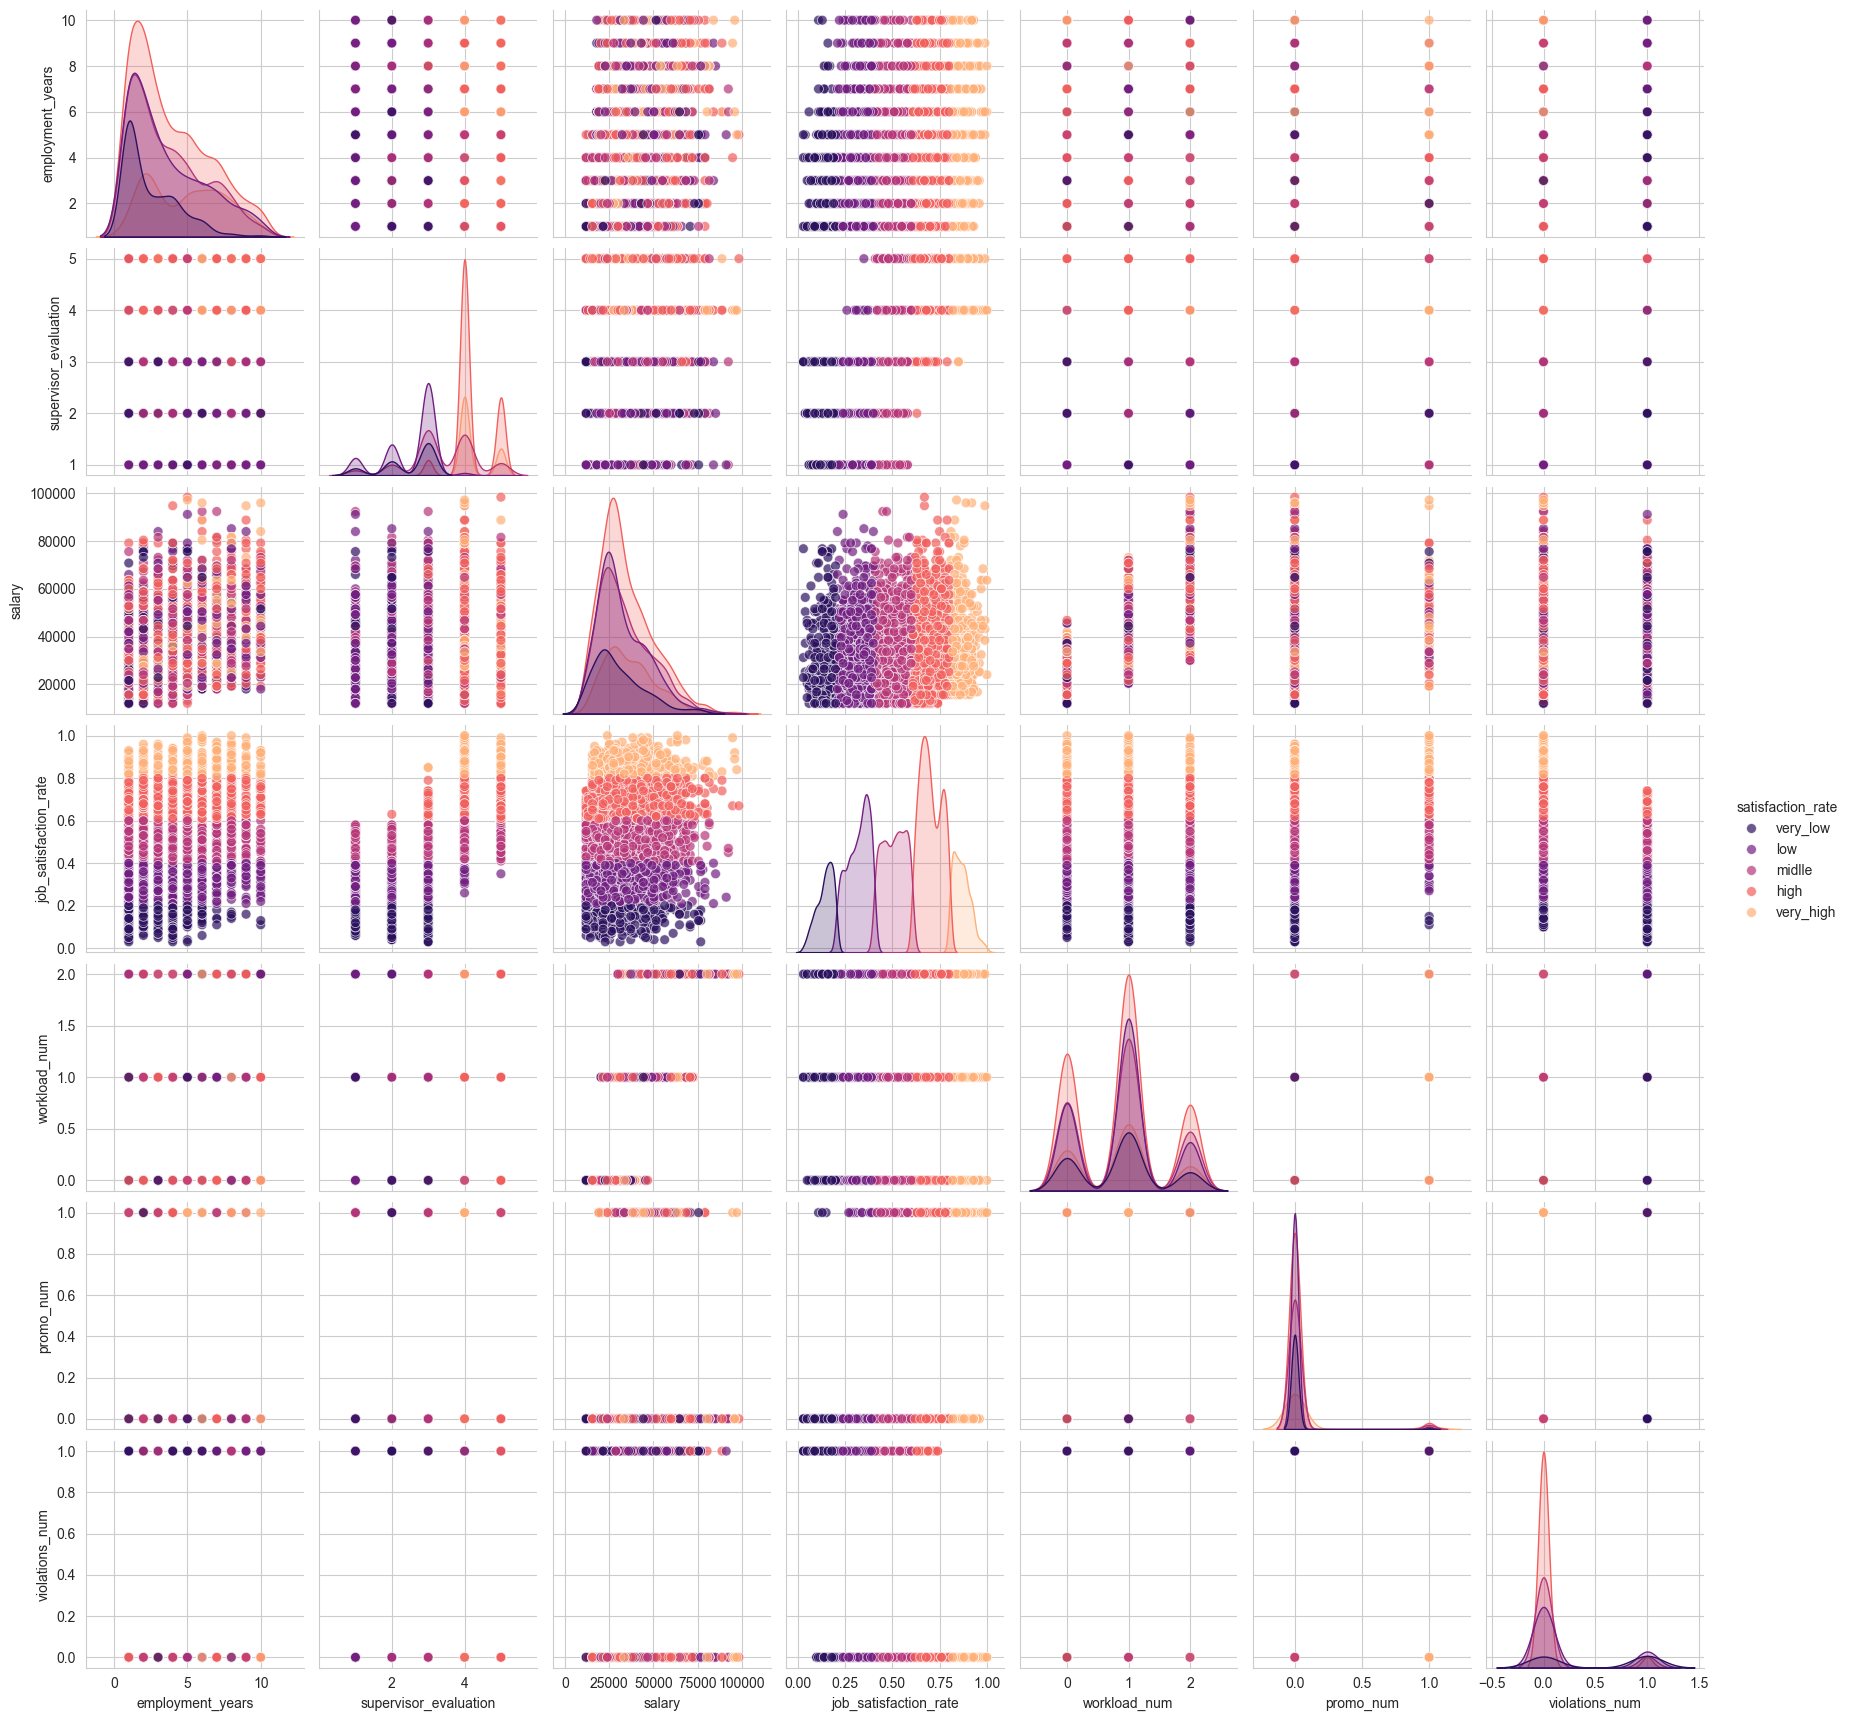

In [51]:
sns.pairplot(
    df_scatter.drop('id', axis=1), 
    hue='satisfaction_rate',  
    palette='magma',  
    diag_kind='auto',  
    plot_kws={'alpha': 0.7, 's': 50}  
);

##### Выводы

- К нашему удивлению больше всего на уровень удовлетворенности оказали влияние такие факторы как : **оценка качества работы сотрудника которую дал руководитель , наличие нарушений за прошлый год , а так же был ли повышен сотрудник** , а не уровень нагруженности и зарплата как могло бы показаться на первый взгляд.

- Используем полученную информацию на этапе постройки "пайплайна" для выбора кодировщика при обработке определенных входящих признаков.

#### Вывод по блоку

- Мы рассмотрели все представленные в данных признаки , каких либо аномалий выявлено не было , данные готовы к постройке модели.

- В ходе исследования проведенного в блоке , была установленна связь "удовлетворенности" сотрудников с такими переменными как : **оценка качества работы сотрудника которую дал руководитель , наличие нарушений за прошлый год , а так же был ли повышен сотрудник**

## Корреляционный анализ.

Перед обучением модели построим несколько матриц корреляции. Для подтверждения выводов выдвинутых на этапе аналитического анализа.

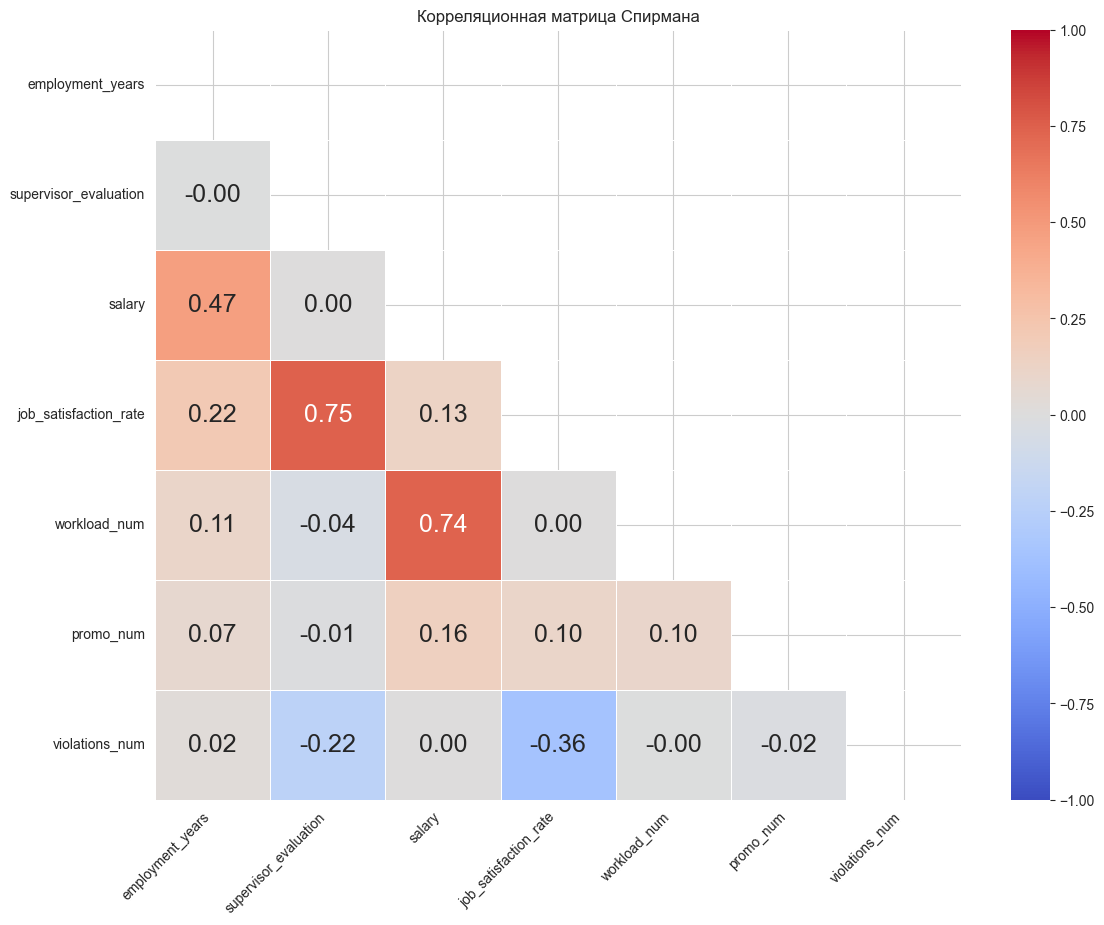

In [52]:
num_cols = df_scatter.drop('id', axis=1).select_dtypes(include=['int64', 'float64']).columns
tri = np.triu(np.ones_like(df_scatter[num_cols].corr(), dtype=bool))
plt.figure(figsize=(13, 10))
heatmap = sns.heatmap(
    df_scatter[num_cols].corr('spearman'), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5,  
    vmin=-1, vmax=1, annot_kws={"size": 18}, mask=tri)     
plt.title("Корреляционная матрица Спирмана")
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.show()

In [53]:
df_train.head(5)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


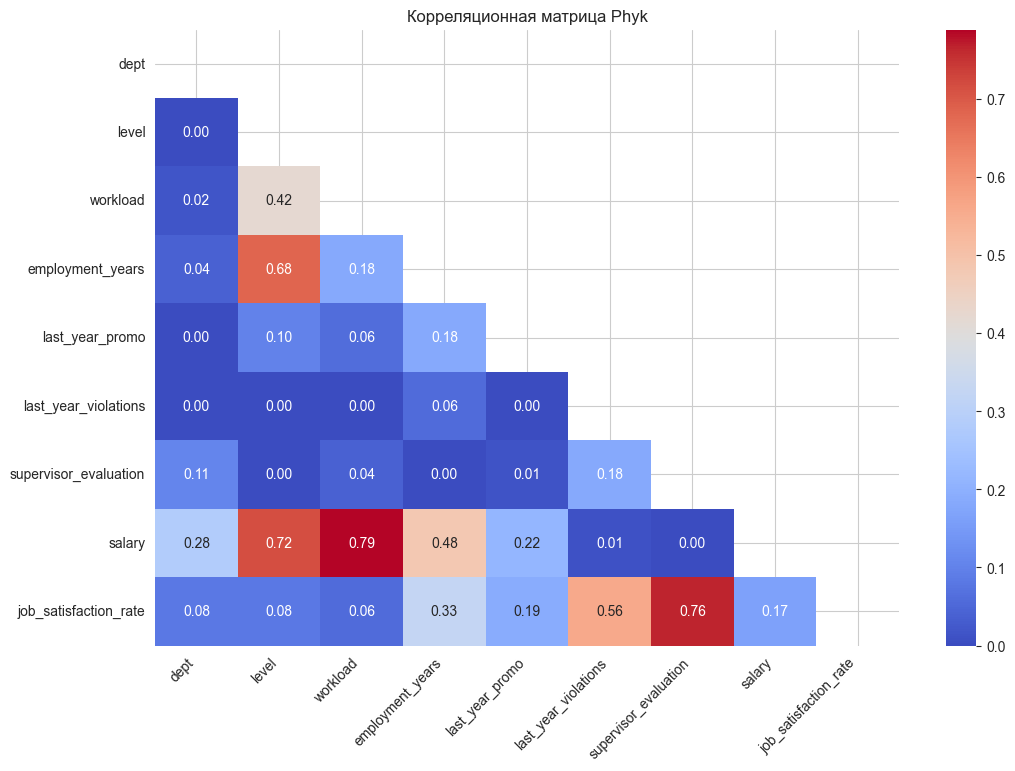

In [54]:
interval_cols = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']
phik_matrix = df_train.drop(['id'], axis=1).phik_matrix(interval_cols=interval_cols)
tri = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=tri);
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.title("Корреляционная матрица Phyk")
plt.show()

Рассмотрим так же индексы корреляции в тестовой выборке.

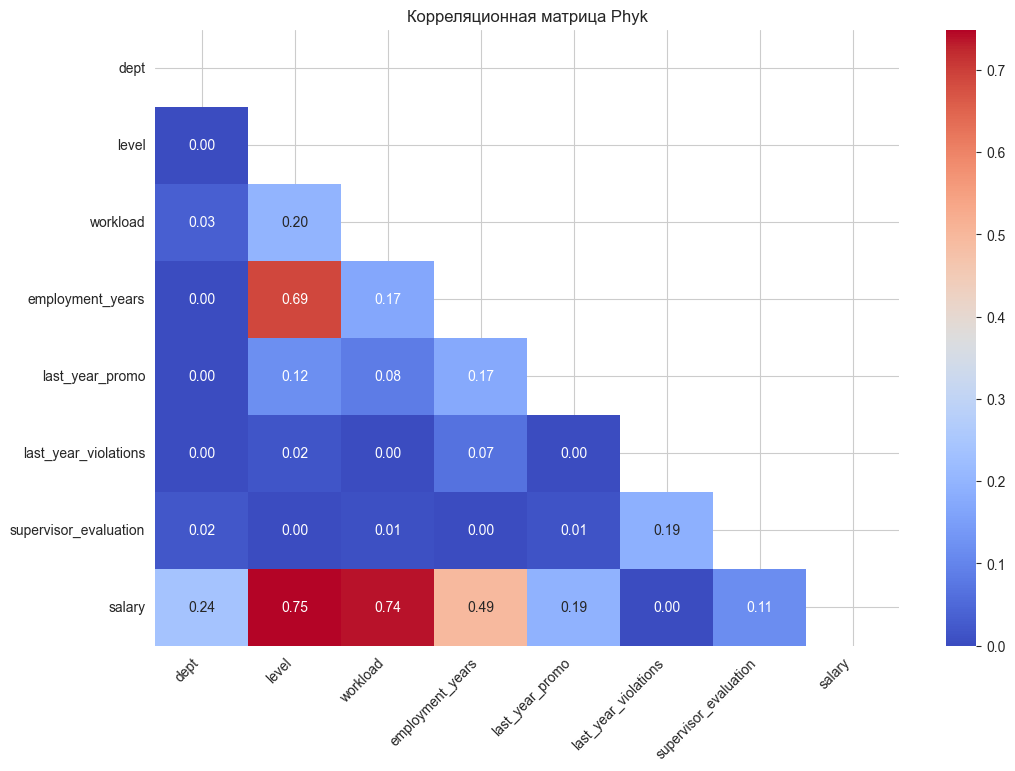

In [55]:
interval_cols = ['employment_years', 'supervisor_evaluation', 'salary']
phik_matrix = df_test.drop(['id'], axis=1).phik_matrix(interval_cols=interval_cols)
tri = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=tri);
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.title("Корреляционная матрица Phyk")
plt.show()

Как видим матрицы корреляции построенные на основе библиотеки *phik* , демонстрируют идентичные результаты интересующих нас переменных.

#### Вывод по блоку

- Наши гипотезы выдвинутые на этапе аналитического анализа полностью подтвердились : *job_satisfaction_rate* имеет сильную корреляцию с **supervisor_evaluation, last_year_promo, last_year_violations**

## Подготовка данных и обучение моделей.

##### Стандартизация пропусков.

На этапе предобработки данных , были найдены неявные пропуски **' '** (пробелы) в датасете df_test. Так как для обработки пропусков внутри "пайплайна" будем использовать *SimpleImputer* который принимает исключительно пропуски формата **np.nan** , заменим пробелы на **NaN** значения.

In [56]:
df_test.replace(' ',  np.nan, inplace=True)
for cat in cat_cols :
    print(f"{cat} : {df_test[cat].unique()}")

dept : ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
level : ['junior' 'middle' 'sinior' nan]
workload : ['medium' 'low' 'high' nan]
last_year_promo : ['no' 'yes']
last_year_violations : ['no' 'yes']


Как видим от неявных дубликатов , удалось избавиться.

### Определение переменных по категориям кодировки.

Разделим признаки на категории , для последующей модификации данных разными способами.

In [57]:
ohe_columns = [
    'dept',
    'last_year_promo',
    'last_year_violations'
]

ord_columns = [
    'level',
    'workload'
]

num_columns = [
    'employment_years',
    'supervisor_evaluation',
    'salary'
]

### Создание выборок 

Переведем полученные нами датасеты , в выборки для обучения модели МО.

In [58]:
X_train = df_train.drop(['id', 'job_satisfaction_rate'], axis=1)
y_train = df_train['job_satisfaction_rate']
X_test = df_test.sort_values(by='id').reset_index(drop=True)
y_test = df_target.sort_values(by='id')['job_satisfaction_rate'].reset_index(drop=True)

#### Пайплайн

##### Обработка данных и сборка "пайплайна"

In [59]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))]
) 

In [60]:
ord_pipe = Pipeline([
    ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[
            ['junior', 'middle', 'sinior'],  
            ['low', 'medium', 'high']        
        ],
        handle_unknown='use_encoded_value',  
        unknown_value=np.nan
    ))
])

In [61]:
# Заглушка
numeric_transformer = Pipeline([
    ('scaler', 'passthrough'),  
    ('preprocessor', None)      
])


In [62]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', numeric_transformer, num_columns)
    ], 
    remainder='passthrough'
)

##### Набор моделей.

In [63]:
models = {
    'SVR': {
        'model': SVR(),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf'],
            'classifier__gamma': ['scale', 'auto']
        }
    },
    'ElasticNet': {
        'model': ElasticNet(random_state=RS),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
            'classifier__alpha': [0.01, 0.1, 1, 10],
            'classifier__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
        }
    
    },
    'LinearRegression': {
        'model': LinearRegression(n_jobs=-1),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
            'classifier__fit_intercept': [True, False],  
            'classifier__positive': [True, False]       
        }
    },
    'DecisionTreeRegressor' : {
        'model' :  DecisionTreeRegressor(random_state=RS),
        'params' : {
            'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
            'classifier__max_depth': [3, 5, 7, None],  # максимальная глубина (None = без ограничений)
            'classifier__min_samples_split': [2, 5, 10],  # минимальное число образцов для разделения узла
            'classifier__min_samples_leaf': [1, 2, 4],  # минимальное число образцов в листе
            'classifier__splitter': ['best', 'random']  # стратегия выбора разбиения
        }
    }

}


##### Создание метрики *smape*

In [64]:
def smape(actual, forecast):
    actual = np.array(actual)
    forecast = np.array(forecast)
    
    denominator = (np.abs(actual) + np.abs(forecast)) / 2.0
    diff = np.abs(forecast - actual) / denominator
    
    diff[denominator == 0] = 0.0
    
    return 100 * np.mean(diff)


In [65]:
smape_scorer = make_scorer(smape, greater_is_better=False)

##### Переборка моделей и вывод результатов.

In [66]:
%%time
results = {}
for name, config in models.items():

    
    pipeline = Pipeline([
        ('preprocessor', data_preprocessor),
        ('classifier', config['model'])
    ])
    
    # Перебор по GridSearch
    grid = GridSearchCV(
        pipeline,
        config['params'],
        scoring=smape_scorer,
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    results[name] = {
        'best_model': grid.best_estimator_,
        'best_params': grid.best_params_,
        'best_score': grid.best_score_,
    }
    
    print(f"{name} completed. Best Smape score: {(grid.best_score_ * -1):.4f}")
for name, res in results.items():
    print(f"{name}:")
    print(f"Best param: {res['best_params']}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
SVR completed. Best Smape score: 14.7022
Fitting 5 folds for each of 60 candidates, totalling 300 fits
ElasticNet completed. Best Smape score: 25.3163
Fitting 5 folds for each of 12 candidates, totalling 60 fits
LinearRegression completed. Best Smape score: 25.0285
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
DecisionTreeRegressor completed. Best Smape score: 14.5828
SVR:
Best param: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf', 'preprocessor__num__scaler': RobustScaler()}
ElasticNet:
Best param: {'classifier__alpha': 0.01, 'classifier__l1_ratio': 0.1, 'preprocessor__num__scaler': StandardScaler()}
LinearRegression:
Best param: {'classifier__fit_intercept': True, 'classifier__positive': False, 'preprocessor__num__scaler': MinMaxScaler()}
DecisionTreeRegressor:
Best param: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5,

In [67]:
pd.set_option('display.max_colwidth', None)

results_df = pd.DataFrame({
    'Model': results.keys(),
    'Train Accuracy': [res['best_score'] for res in results.values()],
    'Best Parameters': [res['best_params'] for res in results.values()]
}).sort_values(by='Train Accuracy', ascending=False)
results_df['Train Accuracy'] = results_df['Train Accuracy'] * -1
display(results_df)


,Model,Train Accuracy,Best Parameters
3,DecisionTreeRegressor,14.582756,"{'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__splitter': 'best', 'preprocessor__num__scaler': RobustScaler()}"
0,SVR,14.702174,"{'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf', 'preprocessor__num__scaler': RobustScaler()}"
2,LinearRegression,25.028455,"{'classifier__fit_intercept': True, 'classifier__positive': False, 'preprocessor__num__scaler': MinMaxScaler()}"
1,ElasticNet,25.316292,"{'classifier__alpha': 0.01, 'classifier__l1_ratio': 0.1, 'preprocessor__num__scaler': StandardScaler()}"


Визуализируем более важные признаки , которые использовала наша лучшая модель.

In [68]:
preprocessor = grid.best_estimator_.named_steps['preprocessor']
X_test_transformed = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()

In [69]:
decision_tree = grid.best_estimator_.named_steps['classifier']
decision_tree

DecisionTreeRegressor(min_samples_leaf=2, min_samples_split=5, random_state=42)

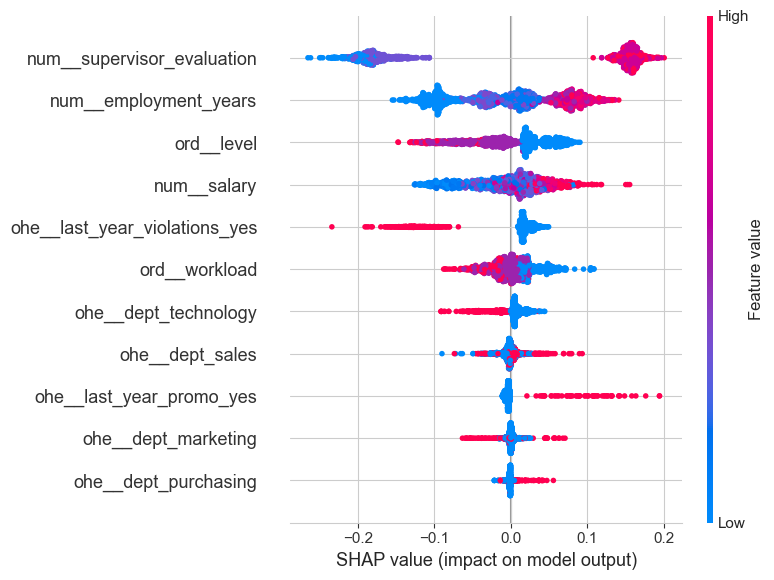

In [70]:
explainer = shap.TreeExplainer(decision_tree)
shap_values = explainer.shap_values(X_test_transformed)
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

Как видим анализ признаков модели , так же полностью согласуется с нашими гипотезами выдвинутыми на этапе исследовательского анализа.

##### Лучшая модель

In [71]:
best_model = results['DecisionTreeRegressor']['best_model']

Получим результат метрики smape на тестовой выборке.

In [72]:
y_pred = best_model.predict(X_test)
print(f"Smape score on test : {smape(y_test, y_pred)}")

Smape score on test : 13.871144090425844


Результат соответствует требованиям заказчика.

### Вывод

- Мы создали "пайплайн" и подготовили наши данные к обучению модели.

- В ходе перебора моделей нами было обучено **324** модели , лучшие результаты показала **SVR** с гиперпараметрами {'C': 1, 'gamma': 'scale', 'kernel': 'rbf', 'scaler': StandardScaler()}

- Для выполнения следующего задания заказчика, мы сохранили нашу лучшую модель.

### Цели исследования.

- Загрузка , обработка и анализ поступивших от заказчика данных , с целью подготовки данных для обучения МО.

- Создание предсказательной модели , которая сможет на основе данных заказчика рассчитать вероятность того, что сотрудник уволится из компании.

### Ход исследования.

- Загрузка и первичное ознакомление с данными.

- Предобработка данных и выявление пропусков.

- Использование созданной нами ранее модели для для выявления корреляции между "удовлетворенностью" и "вероятностью увольнения" сотрудника.

- Исследовательский анализ данных

- Созднание "пайнлайна" с применением обработки данных и использованием различных моделей МО и анализ результатов лучшей модели по метрике ROC-AUC.

- Выводы по вероятном уволднении сотрудников.

### Описание поступивших данных.

`id` — уникальный идентификатор сотрудника;

`dept` — отдел, в котором работает сотрудник;

`level` — уровень занимаемой должности;

`workload` — уровень загруженности сотрудника;

`employment_years` — длительность работы в компании (в годах);

`last_year_promo` — показывает, было ли повышение за последний год;

`last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;

`supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;

`salary` — ежемесячная зарплата сотрудника;

`quit` — увольнение сотрудника из компании.

## Импорт и загрузка данных.

In [73]:
try:
   df_test_quit = pd.read_csv('/datasets/test_features.csv')
except:
   df_test_quit = pd.read_csv(r'C:\Jupi\datasets\test_features_quit.csv')
try:
   df_target_quit = pd.read_csv('/datasests/test_target_quit.csv')
except:
   df_target_quit = pd.read_csv(r'C:\Jupi\datasets\test_target_quit.csv')
try:
    df_train_quit = pd.read_csv('/datasets/train_quit.csv')
except:
    df_train_quit = pd.read_csv(r'C:\Jupi\datasets\train_quit .csv')

### Первичное ознакомление с данными.

#### **df_train_quit**

In [74]:
display(df_train_quit.shape) 
display(df_train_quit.head(5)) 
display(df_train_quit.info()) 
display(df_train_quit.drop('id', axis=1).describe())

(4000, 10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000
mean,3.701500,3.474750,33805.800000
std,2.541852,1.004049,15152.415163
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


При первом ознакомлении , ошибок в данных не обнаружено , повторно поднимем этот вопрос на этапе предобработки.

#### **df_test_quit**

In [75]:
display(df_test_quit.shape) 
display(df_test_quit.head(5)) 
display(df_test_quit.info()) 
display(df_test_quit.drop('id', axis=1).describe())

(2000, 9)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


Датасет **df_test_quit** полностью идентичен **df_test** , а значит содержит все те же дефекты данных в виде пропусков.

#### **df_target_quit**

In [76]:
display(df_target_quit.shape) 
display(df_target_quit.head(5)) 
display(df_target_quit.info()) 
display(df_target_quit.drop('id', axis=1).describe())

(2000, 2)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

,quit
count,2000
unique,2
top,no
freq,1436


Набор данных **df_target_quit** на первый взгляд выглядит нормально.

#### Вывод по блоку

- Данные присланные заказчиком были загружены , при первичном ознакомлении были обнаружены те же проблемы что и при построении модели, несколько пропусков в датасетах **df_test_quit**. Подробней изучим этот дефект на этапе преодобработки.

## Предобработка данных

Выполним более подробный анализ пропусков и дубликатов.

### df_train_quit

In [77]:
check_data_dubmiss(df_train_quit, 'df_train_quit')

,Категория,Параметр,Значение,Детали
0,Общая информация,Название датафрейма,df_train_quit,Размер : 4000 x 10
1,Дубликаты,Всего дубликатов,0,
2,Дубликаты,Примеры дубликатов,False,
3,Пропуски,Всего пропущенных значений,0,0.00% от всех ячеек


In [78]:
for cat in cat_cols :
    print(f"{cat} : {df_train_quit[cat].unique()}")

dept : ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level : ['middle' 'junior' 'sinior']
workload : ['high' 'medium' 'low']
last_year_promo : ['no' 'yes']
last_year_violations : ['no' 'yes']


Набор данных оказался полностью "чист" и готов к передаче в "пайплайн"

### df_test_quit

На этапе загрузки было похоже что **df_test_quit** полностью соответствует **df_test** , выполним те же самые тесты что мы выполняли на этапе постройки модели МО для предсказания "удовлетворенности", что бы полностью в этом удостовериться.

In [79]:
check_data_dubmiss(df_test_quit, 'df_test_quit')

,Категория,Параметр,Значение,Детали
0,Общая информация,Название датафрейма,df_test_quit,Размер : 2000 x 9
1,Дубликаты,Всего дубликатов,0,
2,Дубликаты,Примеры дубликатов,False,
3,Пропущенные значения,dept,2,0.10%
4,Пропущенные значения,level,1,0.05%
5,Пропуски,Всего пропущенных значений,3,0.02% от всех ячеек


In [80]:
df_test_quit[df_test_quit['dept'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800


In [81]:
df_test_quit[df_test_quit['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
312,471990,sales,NaN,low,1,no,no,3,12000


In [82]:
for cat in cat_cols :
    print(f"{cat} : {df_test_quit[cat].unique()}")

dept : ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level : ['junior' 'middle' 'sinior' nan]
workload : ['medium' 'low' 'high' ' ']
last_year_promo : ['no' 'yes']
last_year_violations : ['no' 'yes']


Датасет **df_test_quit** полностью идентичен **df_test** , поэтому применим к нему все те же шаги что мы выполнили в первом задании.

### df_target_quit

In [83]:
check_data_dubmiss(df_target_quit, 'df_target_quit')

,Категория,Параметр,Значение,Детали
0,Общая информация,Название датафрейма,df_target_quit,Размер : 2000 x 2
1,Дубликаты,Всего дубликатов,0,
2,Дубликаты,Примеры дубликатов,False,
3,Пропуски,Всего пропущенных значений,0,0.00% от всех ячеек


In [84]:
df_target_quit['quit'].unique()

array(['yes', 'no'], dtype=object)

Явных дубликатов в целевом признаке , не обнаружилось.

### Вывод по блоку

- Нами были обнаружены аналогичные проблемы что и при выполнении задания №1 , в df_test_quit было обнаружено **3** пропущенных значения.

- Для обработки данных применим те же методы что и на этапе постройки первой модели МО, выполнения этого шага будет выполнено на этапе постройки "пайплайна"

## Исследовательский анализ данных

### Анализ сотрудников склонных к уходу из компании.

Перед обучением модели попытаемся создать портрет сотрудника с высоким шансом ухода.


Посмотрим на распределение зарплат в разрезе департамента и трудовой нагрузки.

In [85]:
df_train_quit.pivot_table(index='quit', columns=['dept', 'workload'], values='salary', aggfunc='mean')

dept                hr                                 marketing  \
workload          high           low        medium          high   
quit                                                               
no        58654.545455  23461.538462  35723.529412  61092.134831   
yes       41485.714286  17815.384615  26454.545455  38580.000000   

dept                                    purchasing                \
workload           low        medium          high           low   
quit                                                               
no        23670.588235  37531.578947  58073.239437  21685.714286   
yes       16749.295775  27233.333333  38000.000000  16592.000000   

dept                           sales                              \
workload        medium          high           low        medium   
quit                                                               
no        35084.584980  54271.153846  22160.975610  34024.263432   
yes       26262.857143  38483.720930  15612.834225  24359.322034   

dept        technology                         
workload          high           low   medium  
quit                                           
no        66423.529412  26407.272727  41100.0  
yes       44760.000000  20290.909091  30748.8

Видим что у ушедших сотрудников ниже зарплата вне зависимости от трудовой нагрузки и рабочего отдела.

Построим "график рассеивания" для более удобного отображения закономерностей.

In [86]:
df_train_quit_scat = df_train_quit.copy()

In [87]:
workload_mapping = {
    'low': 0,
    'medium': 1,
    'high': 2
}

promo_mapping = {
    'no' : 0,
    'yes' : 1
}

violations_mapping = {
    'no' : 0,
    'yes' : 1
}

dept_mapping = {
    'hr' : 0,
    'marketing' : 1,
    'purchasing' : 2,
    'sales' : 3,
    'technology' : 4
}

level_mapping = {
    'junior': 0,
    'middle': 1,
    'sinior': 2
}

df_train_quit_scat['workload_num'] = df_train_quit_scat['workload'].map(workload_mapping)
df_train_quit_scat['promo_num'] = df_train_quit_scat['last_year_promo'].map(promo_mapping)
df_train_quit_scat['violations_num'] = df_train_quit_scat['last_year_violations'].map(violations_mapping)
df_train_quit_scat['dept_num'] = df_train_quit_scat['dept'].map(dept_mapping)
df_train_quit_scat['level_num'] = df_train_quit_scat['level'].map(level_mapping)
df_train_quit_scat.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,workload_num,promo_num,violations_num,dept_num,level_num
0,723290,sales,middle,high,2,no,no,4,54000,no,2,0,0,3,1
1,814010,sales,junior,medium,2,no,no,4,27600,no,1,0,0,3,0
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,1,0,0,2,1
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,1,0,1,3,0
4,910140,marketing,junior,medium,2,no,no,5,25200,no,1,0,0,1,0


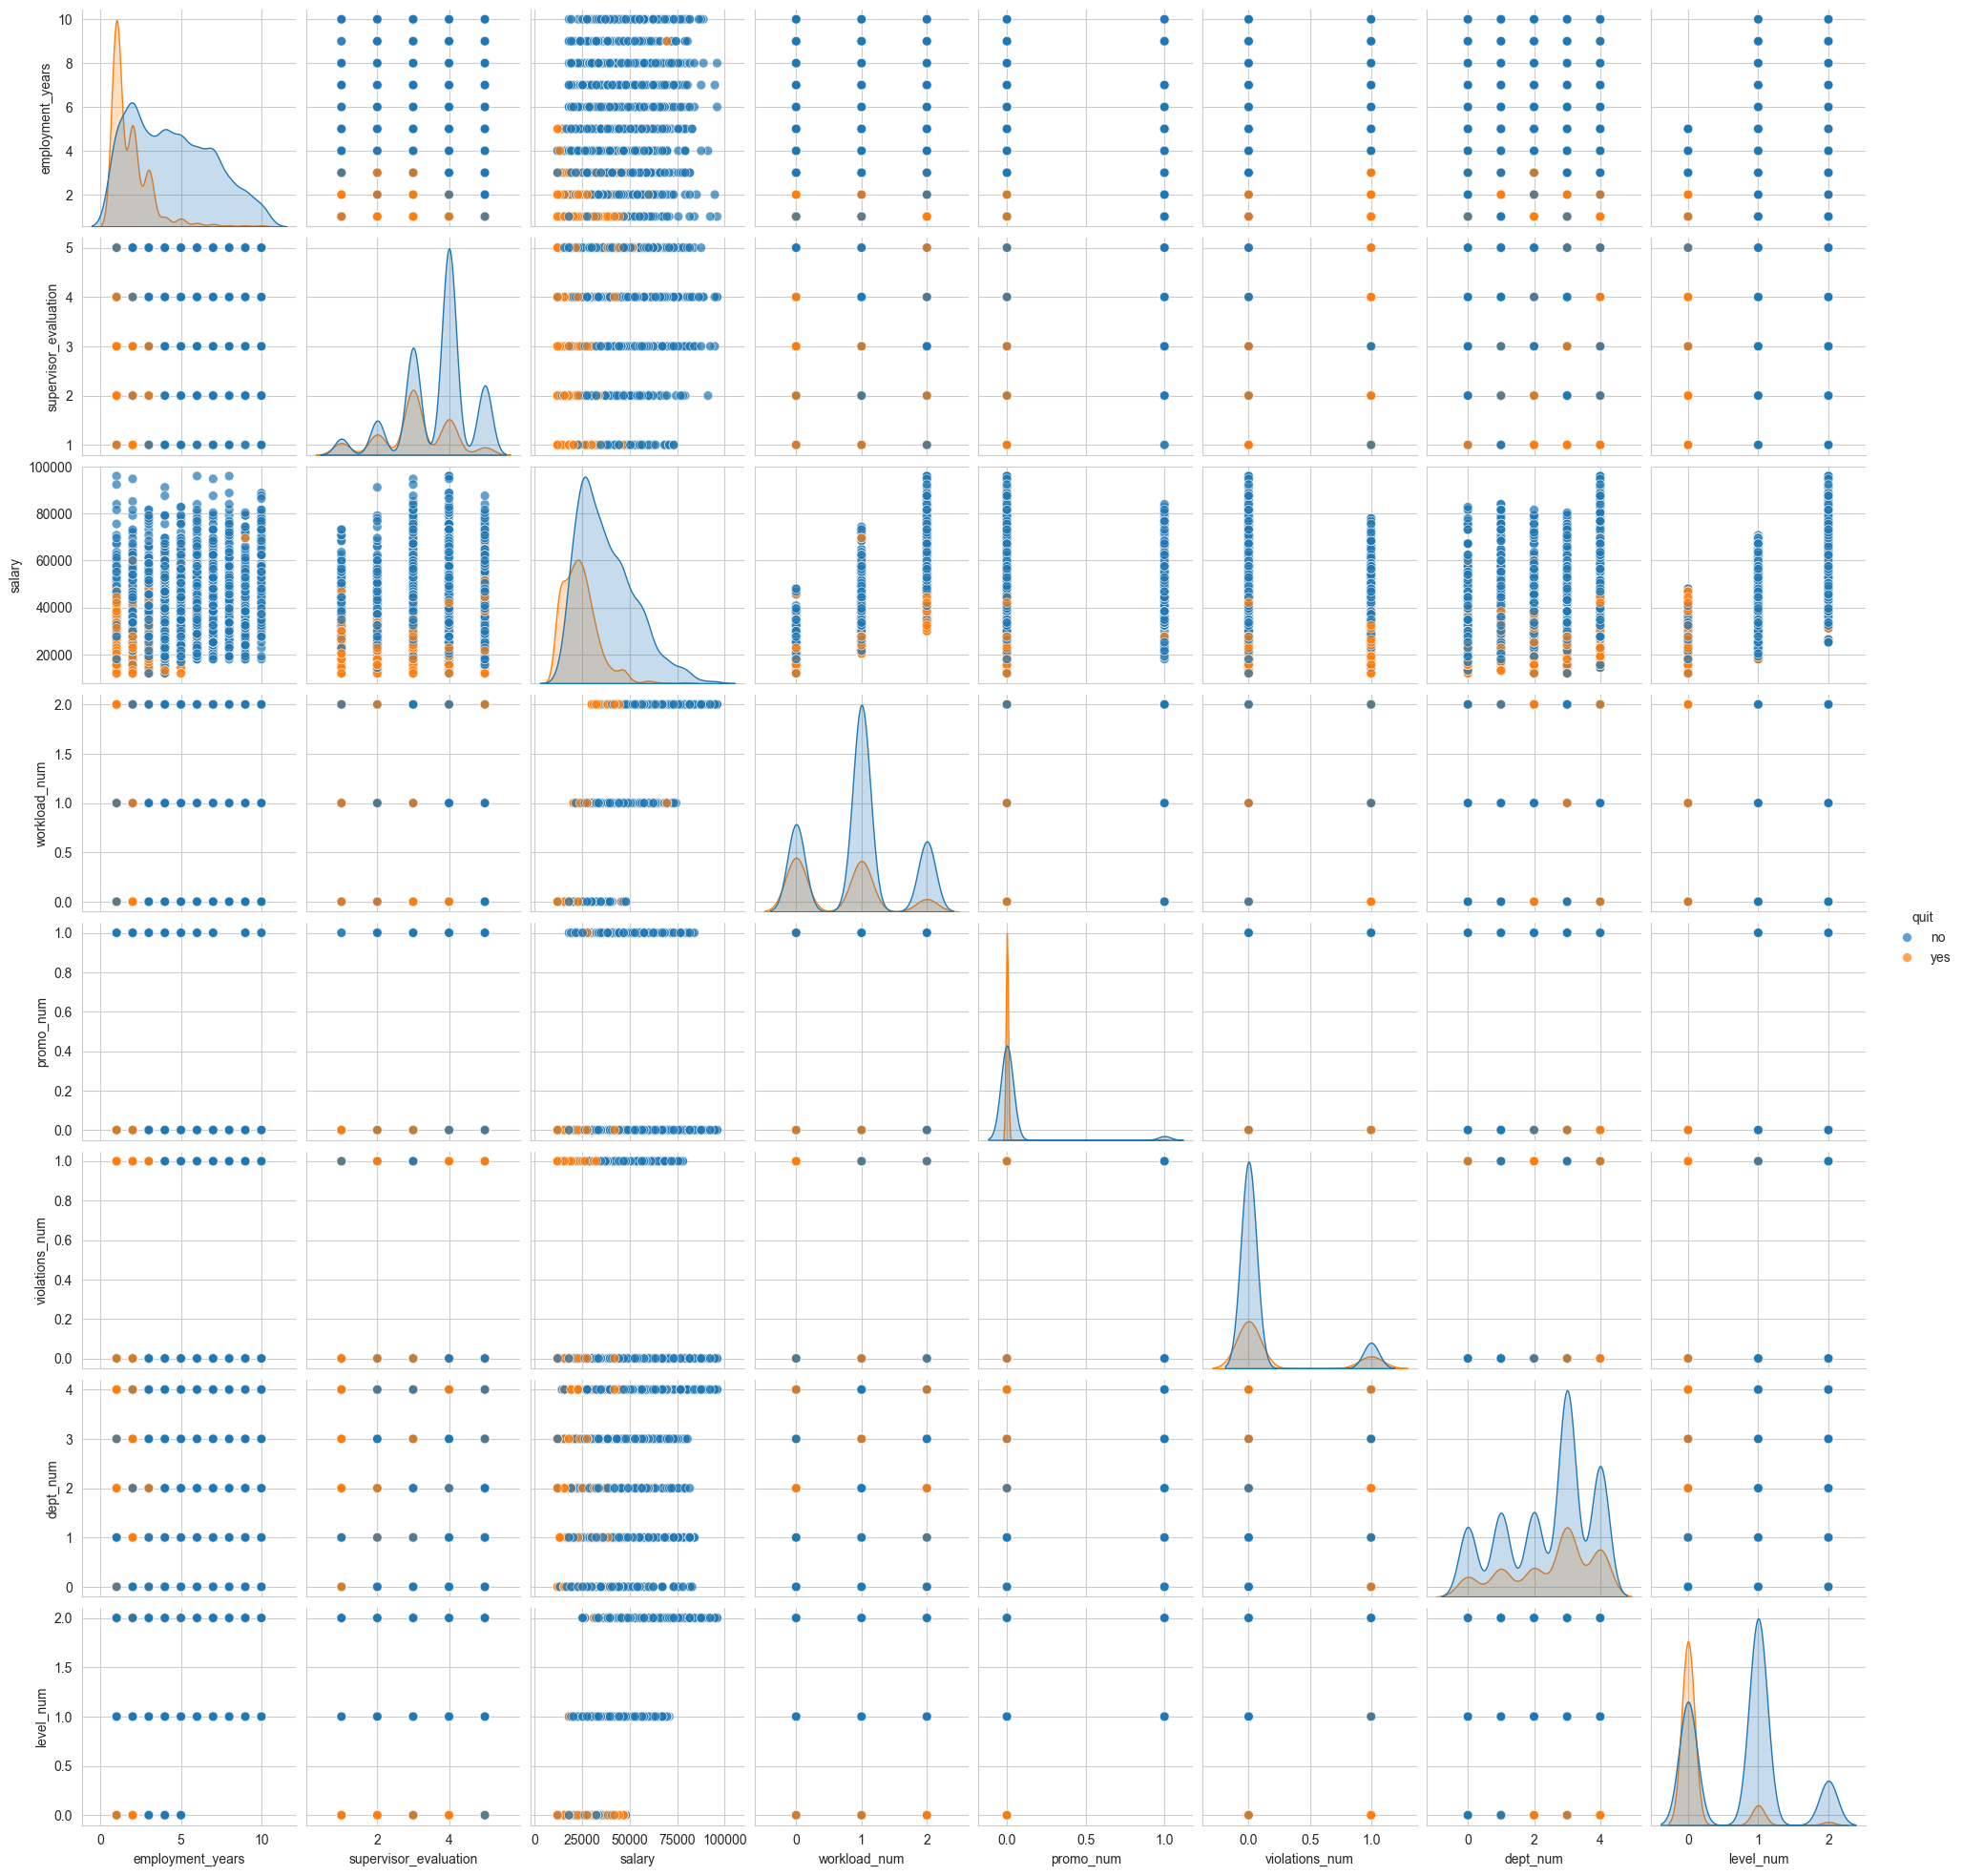

In [88]:
sns.pairplot(
    df_train_quit_scat.drop('id', axis=1), 
    hue='quit',  
    palette=["#1f77b4", "#ff7f0e"],  
    diag_kind='auto',  
    plot_kws={'alpha': 0.7, 's': 50}  
);

Выше мы рассмотрели данные о заплатах и работе в отделе. Рассмотрим увольнения в исключительно разрезе работы в определенном отделе.

In [89]:
perc = df_train_quit.pivot_table(index='quit', columns='dept', values='id', aggfunc='count').reset_index()

#perc.columns = ['']
perc.columns = ['quit', 'hr', 'marketing', 'purchasing', 'sales', 'technology']
#perc['perc'] = perc[perc['quit'] == 'yes'] / perc[perc['quit'] == 'no']
perc

,quit,hr,marketing,purchasing,sales,technology
0,no,348,419,422,1031,652
1,yes,116,163,166,407,276


In [90]:
perc.loc[2] = ['yes_percent'] + [
    (perc.loc[1, col] / (perc.loc[0, col] + perc.loc[1, col])) * 100
    for col in perc.columns if col != 'quit'
]

# Округляем до 2 знаков (только числовые столбцы)
perc.iloc[0:, 1:] = perc.iloc[0:, 1:].round(2)
perc

,quit,hr,marketing,purchasing,sales,technology
0,no,348.0,419.00,422.00,1031.0,652.00
1,yes,116.0,163.00,166.00,407.0,276.00
2,yes_percent,25.0,28.01,28.23,28.3,29.74


Видим что в целом , отдел не влияет на кол-во увольнений.

Что бы окончательно закрепить наши выводы , построим матрицу корреляции при помощи библиотеки *phik*

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary']


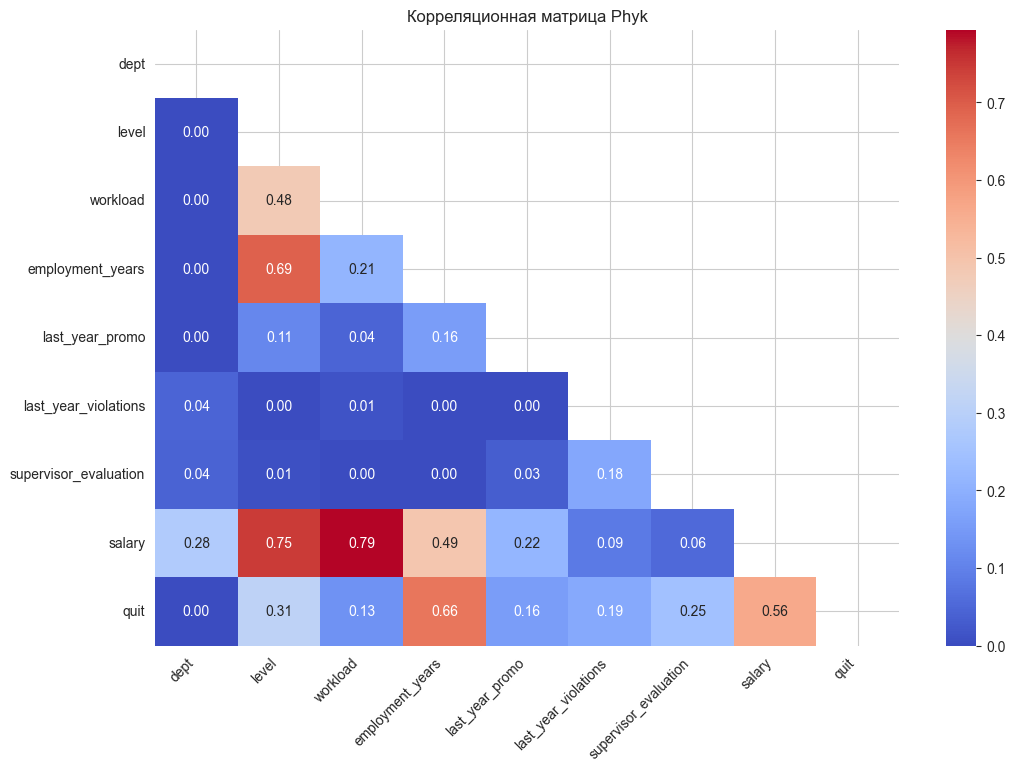

In [91]:
phik_matrix = df_train_quit.drop(['id'], axis=1).phik_matrix()
tri = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=tri);
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.title("Корреляционная матрица Phyk")
plt.show()

#### Вывод

Из проведенного нами анализа , можно сделать следующие выводы о сотруднике склонном к увольнению :

- В основном это "свеженанятые сотрудники" уровня "junior" , которые работают в компании не более 2 лет и соответственно являясь "новичками" получают меньшую оплату за тот же объем работы что и сотрудники с более длительным стажем и более высокой квалификацией.

### Анализ ухода в разрезе удовлетворенности сотрудника работой.

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение.

#### Добавление нового признака к нашей тестовой выборке.

Добавим новый признак "удовлетворенности работой" , получим значения этого признака при помощи разработанной ранее модели МО.

In [92]:
new_job_satis = best_model.predict(df_train_quit)
new_job_satis = pd.DataFrame(new_job_satis, columns=['satisfaction_rate'])
new_job_satis = new_job_satis['satisfaction_rate'].round(2)
df_train_quit_upd = pd.concat([df_train_quit, new_job_satis], axis=1)
df_train_quit_upd.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.61
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.82
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.33
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.34
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.80


Посмотрим на средние значения "удовлетворенности" в разрезе ухода сотрудника.

In [93]:
df_train_quit_upd.pivot_table(index='quit', values='satisfaction_rate', aggfunc=['mean', 'median'])

,mean,median
,satisfaction_rate,satisfaction_rate
quit,,
no,0.591410,0.65
yes,0.399051,0.36


Посмотрим как распределились значения на графике.

Text(0, 0.5, 'Количество сотрудников')

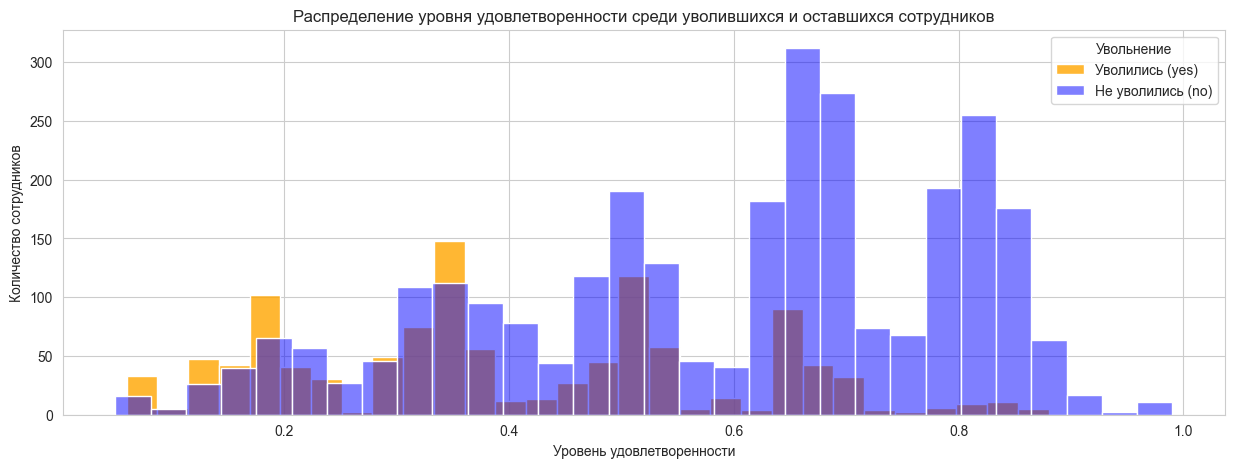

In [94]:
fig , ax = plt.subplots(figsize=(15,5))
sns.histplot(data=df_train_quit_upd[df_train_quit_upd['quit'] == 'yes'], x='satisfaction_rate', color='orange', alpha=0.8, bins=30, label='Уволились (yes)')
sns.histplot(data=df_train_quit_upd[df_train_quit_upd['quit'] == 'no'], x='satisfaction_rate', color='blue', alpha=0.5, bins=30, label='Не уволились (no)')
plt.legend(title='Увольнение')

ax.set_title('Распределение уровня удовлетворенности среди уволившихся и оставшихся сотрудников')
ax.set_xlabel('Уровень удовлетворенности')
ax.set_ylabel('Количество сотрудников')

##### Вывод

На этом этапе мы проверяли догадку отдела аналитики , что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник.

- Мы предсказали при помощи созданной на этапе решения первой задачи модели МО , уровень удовлетворенности сотрудника и добавили данные в тренировочный датафрейм.

- Гипотеза выдвинутая отделом аналитики , полностью подтвердилась , мы видим что начиная с уровня "удовлетворенности" в **0.7** практически отсутствуют увольнения. В свою очередь больше всего уходов сотрудников происходит в сегменте где "удовлетворенность" работой ниже **0.6**.

- Определив зависимость между "целевым признаком" и "уровнем удовлетворенности" , добавим этот признак в обучение модели.

## Обработка данных и постройка модели МО.

### Определение переменных по категориям кодировки.

In [95]:
ohe_columns_quit = [
    'dept',
    'last_year_promo',
    'last_year_violations',
    'level',
    'workload'
]

num_columns_quit = [
    'employment_years',
    'supervisor_evaluation',
    'salary',
    'satisfaction_rate'
]

### Создание выборок 

##### Добавление "satisfaction_rate" в тестовую выборку.

In [96]:
df_test_quit.replace(' ', np.nan, inplace=True)
imputer = SimpleImputer(strategy='most_frequent')  
cat_cols = df_test_quit.select_dtypes(include=['object', 'category']).columns
if not cat_cols.empty:
    imputer_cat = SimpleImputer(strategy='most_frequent')
    df_test_quit[cat_cols] = imputer_cat.fit_transform(df_test_quit[cat_cols])

In [97]:
new_job_satis_test = best_model.predict(df_test_quit)
new_job_satis_test = pd.DataFrame(new_job_satis_test, columns=['satisfaction_rate'])
new_job_satis_test = new_job_satis_test['satisfaction_rate'].round(2)
df_test_quit_upd = pd.concat([df_test_quit, new_job_satis_test], axis=1)
df_test_quit_upd.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.87
1,686555,hr,junior,medium,1,no,no,4,30000,0.68
2,467458,sales,middle,low,5,no,no,4,19200,0.65
3,418655,sales,middle,low,6,no,no,4,19200,0.66
4,789145,hr,middle,medium,5,no,no,5,40800,0.81


In [98]:
X_train_quit = df_train_quit_upd.drop(['id', 'quit'], axis=1)
y_train_quit = df_train_quit_upd['quit']
X_test_quit = df_test_quit_upd.sort_values(by='id')
y_test_quit = df_target_quit.sort_values(by='id')['quit']

### Пайплайн

##### Обработка данных и сборка "пайплайна"

In [99]:
label = LabelEncoder()
y_train_quit = label.fit_transform(y_train_quit)
y_test_quit = label.transform(y_test_quit)

In [100]:
ohe_pipe_quit = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))]
) 

In [101]:
data_preprocessor_quit = ColumnTransformer(
    [
        ('ohe', ohe_pipe_quit, ohe_columns_quit),
        ('num', numeric_transformer, num_columns_quit),
        
    ], 
    remainder='passthrough'
)

##### Набор моделей.

In [102]:
models = {
    
    'LogisticRegression': {
        'model': LogisticRegression(random_state=RS),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
            'classifier__C': [0.01, 0.1, 1, 10],
            'classifier__penalty': ['l1', 'l2'],
            'classifier__solver': ['liblinear'] 
        }
    },
    'DecisionTreeClassifier' : {
        'model' :  DecisionTreeClassifier(random_state=RS),
        'params' : {
            'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
            'classifier__max_depth': [3, 5, 7, None],  #
            'classifier__min_samples_split': [2, 5, 10],  
            'classifier__min_samples_leaf': [1, 2, 4],  
            'classifier__splitter': ['best', 'random']  
        }
    },
    'SVC': {
        'model': SVC(probability=True, random_state=RS, class_weight='balanced'),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf'],
            'classifier__gamma': ['scale', 'auto']
        }
    }
}


##### Переборка моделей и вывод результатов.

In [103]:
%%time
results_quit = {}
for name, config in models.items():

    
    pipeline = Pipeline([
        ('preprocessor', data_preprocessor_quit),
        ('classifier', config['model'])
    ])
    
    # Перебор по GridSearch
    grid_quit = GridSearchCV(
        pipeline,
        config['params'],
        scoring='roc_auc',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    
    grid_quit.fit(X_train_quit, y_train_quit)
    y_pred_proba = grid_quit.predict_proba(X_test_quit)[:, 1]

    results_quit[name] = {
        'best_model': grid_quit.best_estimator_,
        'best_params': grid_quit.best_params_,
        'best_score': grid_quit.best_score_,
    }
    
    print(f"{name} completed. Best ROC-AUC score: {(grid_quit.best_score_ ):.4f}")
for name, res in results_quit.items():
    print(f"{name}:")
    print(f"Best param: {res['best_params']}")
    

Fitting 5 folds for each of 24 candidates, totalling 120 fits
LogisticRegression completed. Best ROC-AUC score: 0.9325
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
DecisionTreeClassifier completed. Best ROC-AUC score: 0.9339
Fitting 5 folds for each of 36 candidates, totalling 180 fits
SVC completed. Best ROC-AUC score: 0.9337
LogisticRegression:
Best param: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'preprocessor__num__scaler': StandardScaler()}
DecisionTreeClassifier:
Best param: {'classifier__max_depth': 7, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__splitter': 'random', 'preprocessor__num__scaler': StandardScaler()}
SVC:
Best param: {'classifier__C': 0.1, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf', 'preprocessor__num__scaler': StandardScaler()}
CPU times: total: 3.64 s
Wall time: 18.2 s


In [104]:
pd.set_option('display.max_colwidth', None)

results_df_quit = pd.DataFrame({
    'Model': results_quit.keys(),
    'Train Accuracy': [res['best_score'] for res in results_quit.values()],
    'Best Parameters': [res['best_params'] for res in results_quit.values()]
}).sort_values(by='Train Accuracy', ascending=False)
display(results_df_quit)


,Model,Train Accuracy,Best Parameters
1,DecisionTreeClassifier,0.933908,"{'classifier__max_depth': 7, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__splitter': 'random', 'preprocessor__num__scaler': StandardScaler()}"
2,SVC,0.933666,"{'classifier__C': 0.1, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf', 'preprocessor__num__scaler': StandardScaler()}"
0,LogisticRegression,0.932468,"{'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'preprocessor__num__scaler': StandardScaler()}"


### Сохранение модели и получение предсказаний.

In [105]:
best_model_quit = results_quit['SVC']['best_model']
quit_pred = best_model_quit.predict_proba(X_test_quit)[:,1]
quit_pred = pd.DataFrame(quit_pred, columns=['quit_probability'])
df_test_all_pred = pd.concat([df_test_quit_upd, quit_pred], axis=1)
df_test_all_pred

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,satisfaction_rate,quit_probability
0,485046,marketing,junior,medium,2,no,no,5,28800,0.87,0.165170
1,686555,hr,junior,medium,1,no,no,4,30000,0.68,0.068914
2,467458,sales,middle,low,5,no,no,4,19200,0.65,0.018003
3,418655,sales,middle,low,6,no,no,4,19200,0.66,0.005221
4,789145,hr,middle,medium,5,no,no,5,40800,0.81,0.016172
...,...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0.53,0.015895
1996,109582,technology,middle,low,3,no,no,2,21600,0.14,0.041674
1997,305653,technology,junior,low,1,no,no,3,14400,0.24,0.888659
1998,160233,technology,middle,low,8,no,no,1,32400,0.55,0.010860


**Получим значение метрики ROC-AUC на тестовой выборке.**

In [106]:
y_pred = best_model_quit.predict_proba(X_test_quit)[:,1]

In [107]:
roc_auc_score(y_test_quit, y_pred)

np.float64(0.9247731829945278)

### Вывод

- На этом этапе исследования мы обработали поступившие от заказчика данные и обучили **276** моделей , отобрав лучшие.

- Все выбранные нами модели показали отличные , близкие к друг другу результаты , с небольшим отрывом лидером оказалась модель **SVC**. На этапе исследовательского анализа мы рассмотрели все признаки и между ними была заметна явная линейная зависимость, поэтому модели показали такую незначительную разницу в результатах. Несмотря на то что "победителем" оказалась **SVC** , в зависимости от дальнейших целей бизнеса , если потребуешься более детальная интерпретация признаков я бы рекомендовал отдать предпочтение **LogisticRegression** , как более гибкой модели в этом вопросе.

# Общий вывод

Нам поступил заказ от HR компании «Работа с заботой» с просьбой о разработке моделей МО , которые бы успешно помогли бы бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. Выполненная нами работа разделилась на два шага : построение модели предсказывающей уровень "удовлетворенности" сотрудников , и создание модели МО для предсказания возможности увольнения сотрудника.


**Шаг №1** Построение модели предсказывающей уровень "удовлетворенности" сотрудников.

- Мы получили от заказчика данные , загрузив их и первично ознакомившись. Мы обнаружили несколько пропусков , в остальном данные были достаточно высокого качества.

- На этапе предобработки данных , мы подробнее изучили вопрос пропусков озвученный в пункте выше , а так же на удалось обнаружить несколько неявных пропусков (пробелов). Мы провели аналитику и определялись со стратегией замены , так как пропуски были в категориальных переменных и не имели значительного веса на целевой признак , мы решили выполнить обработку в процессе построения "пайплайна" заменив пропуски самым часто врезаемым значением.

- На блоке исследовательского анализа , мы попытались выявить закономерности в данных и выдвинуть некоторые гипотезы. Мы обнаружили что удовлетворенность сотрудников в большей степени завесила не от зарплаты как мог ло бы показаться на первый взгляд , а от таких параметров как : **оценка качества работы сотрудника которую дал руководитель , наличие нарушений за прошлый год , а так же был ли повышен сотрудник**.

- При построение модели МО , мы использовали "пайплайн" , который в автоматическом режиме обработал данные и перебрал **324** варианта. Лучшей по метрике *smape* оказалась **SVR** с гиперпараметрами {'C': 1, 'gamma': 'scale', 'kernel': 'rbf', 'scaler': StandardScaler()}. Мы сохранили лучшую модель для дальнейшего использования в задаче №2 для предсказания "удовлетворенности" сотрудников.


**Шаг №2** Создание модели МО для предсказания возможности увольнения сотрудника.

- Мы выполнили аналогичные шаги по загрузке и обработке данных представленные в *шаге №1*.

- В ходе исследовательского анализа , мы определились с портретом сотрудника планирующего уход из компании. Это оказались "свеженанятые сотрудники" уровня "junior" , которые работают в компании не более 2 лет и соответственно являясь "новичками" получают меньшую оплату за тот же объем работы что и сотрудники с более длительным стажем и более высокой квалификацией.

- Мы использовали модель из *шага №1* для предсказания уровня "удовлетворенности" и добавления данных в тестовую и тренировочную выборки.

- Отдел аналитики попросил нас проверить гипотезу о том что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. В ходе анализа свежих данных , жта гипотеза полностью подтвердилась.

- Мы по аналогии с *шагом №1* построили "пайплайн" в этот раз для определения лучшей модели было построено **276** моделей. Лучший результат показала модель на основе **SVC** , но разница в сравнении с **DecisionTreeClassifier и LogisticRegression** оказалась не значительной в районе **0.004** по метрике **ROC-AUC**. Если заказчику потребуется более глубокий анализ признаков , то рекомендацией было бы использовать **LogisticRegression** как более легко интерпретируемую модель.

## Рекомендации на основе проведенного анализа

**В ходе нашего исследования мы определились с целевой группой с которой необходимо работать, вот следующие рекомендации :**

Адаптационные программы: Улучшить систему onboarding, назначить менторов, чтобы помочь новым сотрудникам быстрее влиться в коллектив.

Регулярная обратная связь: Проводить ежеквартальные встречи с HR и руководителями для обсуждения проблем и ожиданий.

Грейдинг и карьерный рост: Четко обозначить путь роста (например, переход из Junior в Middle через 1.5–2 года при выполнении KPI).

Финансовая мотивация: Рассмотреть возможность бонусов или повышения зарплаты после успешного прохождения испытательного срока.

Объективная оценка performance: Внедрить прозрачную систему KPI и регулярный фидбек от руководителей.

Борьба с дискриминацией: Если нарушения (например, необоснованные выговоры) влияют на увольнения, пересмотреть систему контроля.

Система поощрений: Чаще повышать сотрудников (даже незначительно — например, в должности или звании) за хорошую работу.

**На основании построенных моделей , делать предсказания для принятия превентивных мер , таких как :**

Раннее вмешательство: HR-отдел может связываться с сотрудниками из группы риска и предлагать решения (например, обучение, смена проекта).

Анализ причин: Регулярно проверять, какие факторы (например, низкая оценка руководителя) чаще ведут к уходу.

Employee Satisfaction Score (ESS): Регулярно измерять уровень удовлетворенности (например, через анонимные опросы).

Retention Rate по стажу: Отслеживать, на каком этапе чаще уходят сотрудники (первые 6 месяцев, 1–2 года и т.д.).

**Общие рекомендации:**


Командные мероприятия: Укреплять вовлеченность через тимбилдинги и нетворкинг.

Гибкие условия работы: Рассмотреть возможность гибридного графика или дополнительных дней отпуска для снижения выгорания.